In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import dlib
import pickle
import h5py
import cv2
import scipy

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

Getting FER2013 dataset

In [0]:
dataset = pd.read_csv('/content/drive/My Drive/Datasets/fer2013.csv')

In [4]:
dataset.head()

emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

In [0]:
def get_images(usage):
  df = dataset[dataset['Usage'] == usage]
  y = tf.keras.utils.to_categorical(df['emotion'])
  X = np.array([values.split() for values in df['pixels']])
  X = X.astype(np.float).reshape(len(df), 48, 48, 1)
  return (X, y)

In [0]:
X_train, y_train = get_images('Training')
X_test, y_test =  get_images('PublicTest')
X_validate, y_validate = get_images('PrivateTest')

In [7]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

print('X_validate:', X_validate.shape)
print('y_validate:', y_validate.shape)

X_train: (28709, 48, 48, 1)
y_train: (28709, 7)
X_test: (3589, 48, 48, 1)
y_test: (3589, 7)
X_validate: (3589, 48, 48, 1)
y_validate: (3589, 7)


In [0]:
def get_label(arg):
  labels = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Sad',5:'Surprise',6:'Neutral'}
  return (labels.get(arg,"Invalid Emotion"))

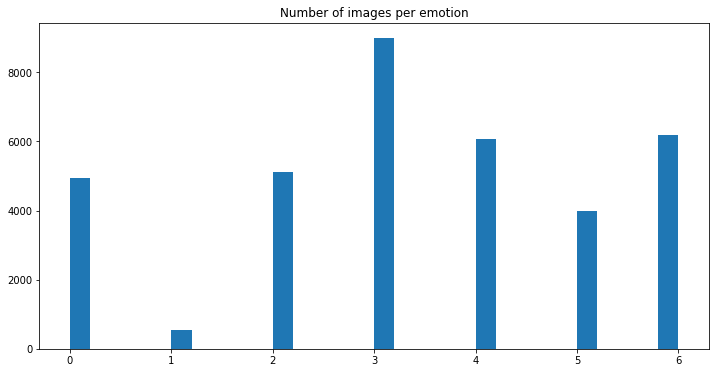

In [9]:
plt.figure(figsize=(12,6))
plt.hist(dataset['emotion'], bins=30)
plt.title("Number of images per emotion")
plt.show()

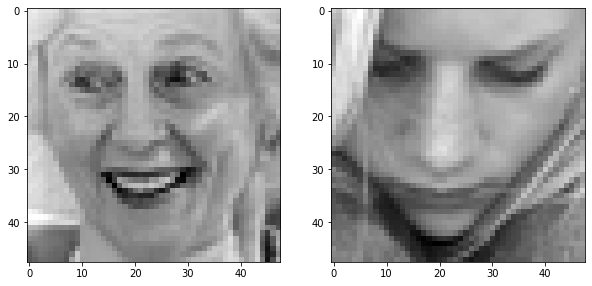

In [10]:
plt.figure(figsize=[10,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(np.squeeze(X_train[25,:,:], axis = 2), cmap='gray')

# Display the first image in testing data
plt.subplot(122)
plt.imshow(np.squeeze(X_test[26,:,:], axis = 2), cmap='gray')

In [0]:
train_data = X_train.astype('float32')
test_data = X_test.astype('float32')
val_data = X_validate.astype('float32')

train_data /= 255
test_data /= 255
val_data /= 255

In [0]:
def detect_face(frame):
  #Cascade classifier pretrained model
  cascPath = '/content/drive/My Drive/BE Project/sarvesh/haarcascades/haarcascade_frontalface_default.xml'
  faceCascade = cv2.CascadeClassifier(cascPath)
  #BGR to gray conversion
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  #Cascade multiscale classifier
  detected_faces = faceCascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=6,
                                                minSize=(48,48),
                                                flags=cv2.CASCADE_SCALE_IMAGE)
  coord=[]
  for x, y, w, h in detected_faces:
    if w>100:
      sub_img=frame[y:y+h,x:x+w]
      coord.append([x,y,w,h])
  return gray, detected_faces, coord

In [0]:
def extract_face_features(faces, offset_coeffs=(0.075,0.05)):
  gray=faces[0]
  detected_face=faces[1]
  new_face=[]
  for det in detected_face:
    x,y,w,h=det
    #offset-coeff, np.floor takes lowest int (delete border of image)
    hor_offset=np.int(np.floor(offset_coeffs[0]*w))
    ver_offset=np.int(np.floor(offset_coeffs[1]*h))
    extracted_face=gray[y+ver_offset:y+h, x+hor_offset:x-hor_offset+w]
    #zoom
    new_extracted_face=scipy.ndimage.zoom(extracted_face,(48/extracted_face.shape[0],48/extracted_face.shape[1]))
    new_extracted_face=new_extracted_face.astype(np.float32)
    #scale
    new_extracted_face/=float(new_extracted_face.max())
    new_face.append(new_extracted_face)
  return new_face

In [0]:
from google.colab.patches import cv2_imshow

Model

In [0]:
inputs = tf.keras.layers.Input(shape=(48,48, 1))
x = tf.keras.layers.Conv2D(32, 5, strides = 2, padding='valid')(inputs)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='valid')(x)
x = tf.keras.layers.LayerNormalization()(x)
#parallel featext block1
#path1
x_1 = tf.keras.layers.Conv2D(64, 5, strides = 2, padding='valid')(x)
x_1 = tf.keras.layers.Activation('relu')(x_1)

x_1 = tf.keras.layers.Conv2D(128, 3, strides = 1, padding='same')(x_1)
x_1 = tf.keras.layers.Activation('relu')(x_1)

#path2
x_2 = tf.keras.layers.Conv2D(32, 3, strides = 2, padding='same')(x)
x_2 = tf.keras.layers.Activation('relu')(x_2)

x_2 = tf.keras.layers.Conv2D(64, 3, strides = 1, padding='valid')(x_2)
x_2 = tf.keras.layers.Activation('relu')(x_2)

x_2 = tf.keras.layers.Conv2D(128, 1, strides = 1, padding='valid')(x_2)
x_2 = tf.keras.layers.Activation('relu')(x_2)

#concatenate
x_3 = tf.keras.layers.Concatenate(axis = 3)([x_1, x_2])
x_3 = tf.keras.layers.MaxPooling2D(3, strides=2, padding='valid')(x_3)

# #parallel featext block1
# #path1
# x_4 = tf.keras.layers.Conv2D(64, 5, strides = 2, padding='same')(x_3)
# x_4 = tf.keras.layers.Activation('relu')(x_4)

# x_4 = tf.keras.layers.Conv2D(128, 3, strides = 1, padding='same')(x_4)
# x_4 = tf.keras.layers.Activation('relu')(x_4)

# #path2
# x_5 = tf.keras.layers.Conv2D(32, 3, strides = 2, padding='same')(x_3)
# x_5 = tf.keras.layers.Activation('relu')(x_5)

# x_5 = tf.keras.layers.Conv2D(64, 3, strides = 1, padding='same')(x_5)
# x_5 = tf.keras.layers.Activation('relu')(x_5)

# x_5 = tf.keras.layers.Conv2D(128, 1, strides = 1, padding='same')(x_5)
# x_5 = tf.keras.layers.Activation('relu')(x_5)

# #concatenate
# x_6 = tf.keras.layers.Concatenate(axis = 3)([x_4, x_5])



x_6 = tf.keras.layers.Flatten()(x_3)
#x_3 = tf.keras.layers.Dense(128,activation='relu')(x_3)
x_6 =tf.keras.layers.Dropout(0.5)(x_6)
x_6 = tf.keras.layers.Dense(7)(x_6)
x_6 = tf.keras.layers.Activation('softmax')(x_6)

In [16]:
model = tf.keras.models.Model(inputs = inputs , outputs = x_6)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 22, 22, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 22, 22, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 10, 10, 32)   0           activation[0][0]                 
______________________________________________________________________________________________

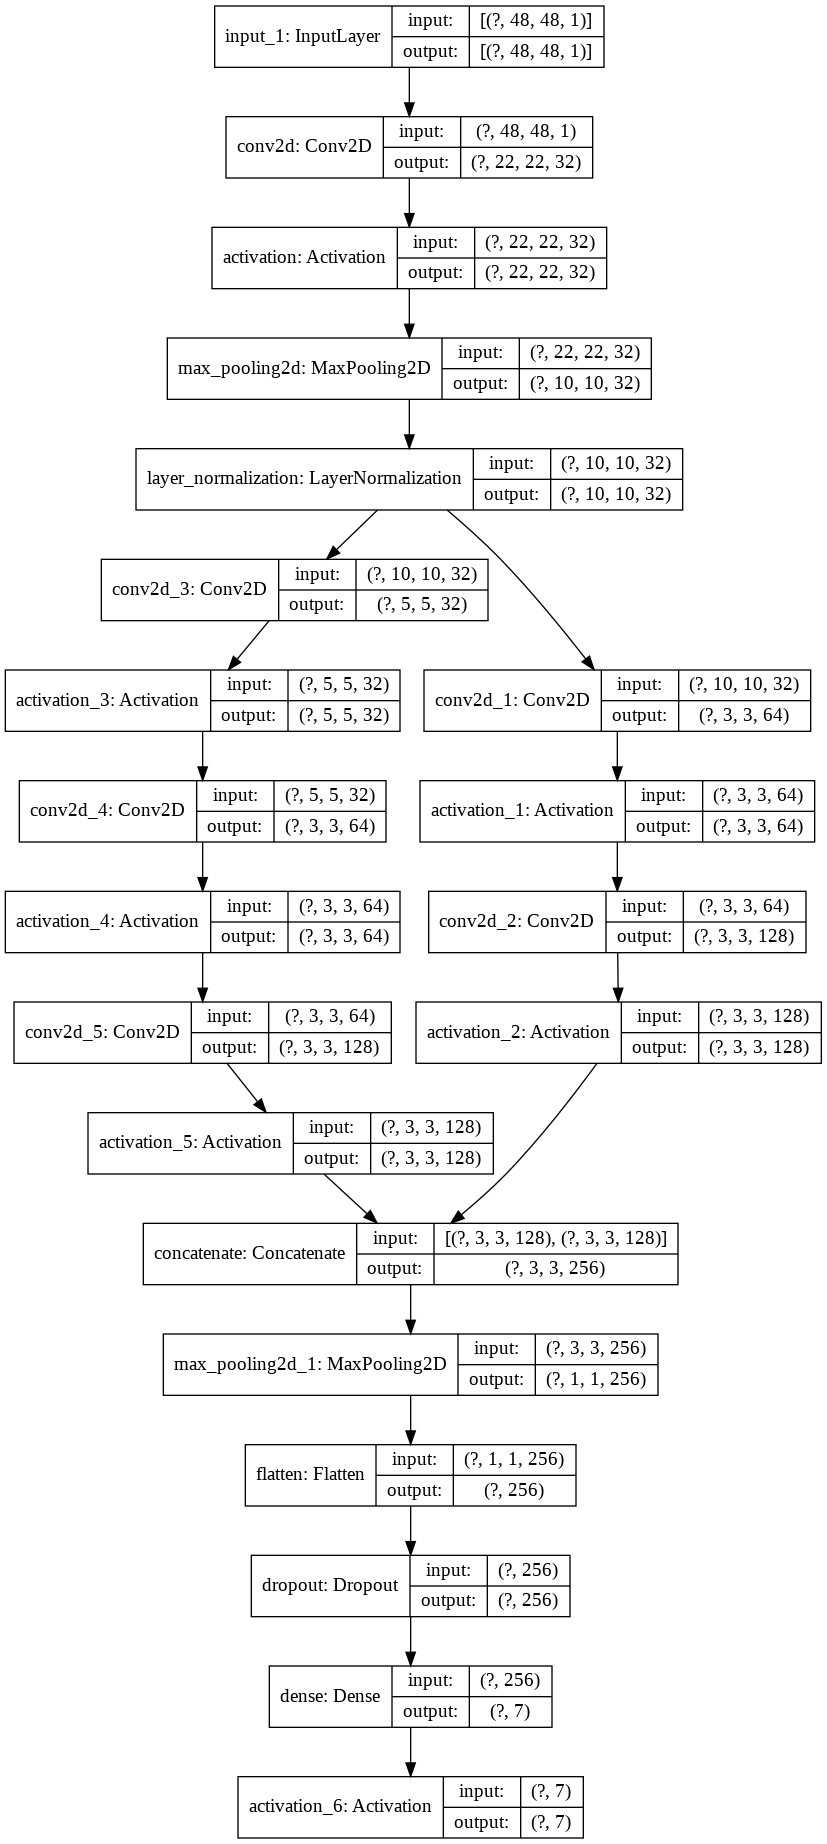

In [17]:
tf.keras.utils.plot_model(model, to_file='simple_model_layernorm_fer.png', show_shapes=True, show_layer_names=True)

Training the model

In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
   zoom_range=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

In [0]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
lr_reducer_v = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)

tensorboard_v = tf.keras.callbacks.TensorBoard(log_dir='./logs')

early_stopper_v = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')

checkpointer_v = tf.keras.callbacks.ModelCheckpoint('simple_model_layernorm_fer.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [21]:
batch_size=256
epochs=100
history = model.fit(
    datagen.flow(train_data, y_train, batch_size=batch_size),
    #train_data, y_train,

    #batch_size=batch_size,
    steps_per_epoch=int(np.ceil(train_data.shape[0] / float(batch_size))),
    epochs = epochs,
    verbose=1,
    shuffle=True,
    validation_data=(val_data, y_validate),
    callbacks=[lr_reducer_v, tensorboard_v, early_stopper_v, checkpointer_v]
)

Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 1.8262 - accuracy: 0.2431
Epoch 00001: val_loss improved from inf to 1.78891, saving model to simple_model_layernorm_fer.h5
113/113 [==============================] - 15s 133ms/step - loss: 1.8262 - accuracy: 0.2431 - val_loss: 1.7889 - val_accuracy: 0.2510 - lr: 0.0010
Epoch 2/100
112/113 [============================>.] - ETA: 0s - loss: 1.7811 - accuracy: 0.2625
Epoch 00002: val_loss improved from 1.78891 to 1.74223, saving model to simple_model_layernorm_fer.h5
113/113 [==============================] - 14s 127ms/step - loss: 1.7811 - accuracy: 0.2625 - val_loss: 1.7422 - val_accuracy: 0.2937 - lr: 0.0010
Epoch 3/100
112/113 [============================>.] - ETA: 0s - loss: 1.7316 - accuracy: 0.2973
Epoch 00003: val_loss improved from 1.74223 to 1.63982, saving model to simple_model_layernorm_fer.h5
113/113 [==============================] - 14s 126ms/step - loss: 1.7318 - accuracy: 0.2972 - val_loss: 1.6398 - 

Text(0.5, 1.0, 'Accuracy Curves')

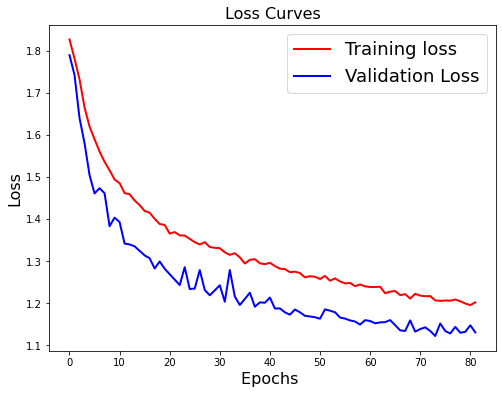

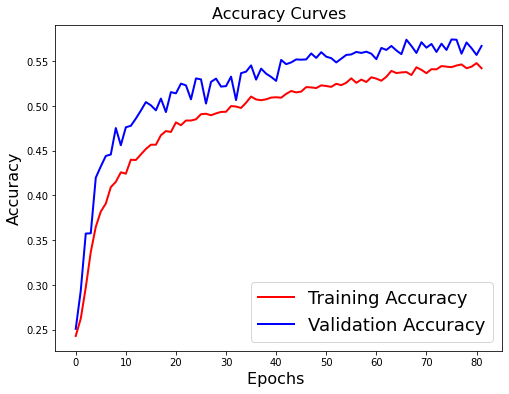

In [22]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [23]:
score = model.evaluate(test_data, y_test)

113/113 [==============================] - 1s 5ms/step - loss: 1.1626 - accuracy: 0.5592


Visualize layers and outputs

In [0]:
layer_outputs = [layer.output for layer in model_fervideo_1.layers[:22]]
#extract outputs of top 22 layers
activation_model = tf.keras.models.Model(inputs=model_fervideo_1.input, outputs=layer_outputs)

In [0]:
layer_names = []
for layer in model_fervideo_1.layers[:22]:
  layer_names.append(layer.name)


In [0]:
to_predict=np.reshape(face.flatten(), (1,48,48,1))
res=model_fervideo_1.predict(to_predict)
activations = activation_model.predict(to_predict)

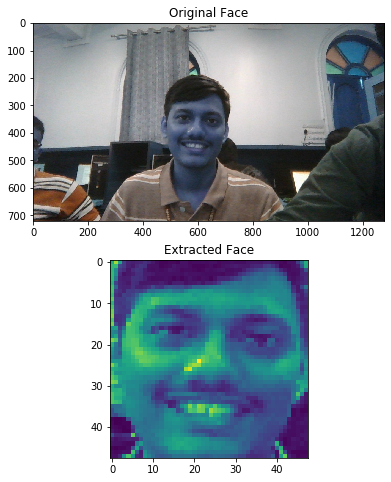

In [0]:
plt.figure(figsize=(12,8))

plt.subplot(211)
plt.title("Original Face")
plt.imshow(sample_face)

plt.subplot(212)
plt.title("Extracted Face")
plt.imshow(face)

plt.show()

In [0]:
images_per_row=64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


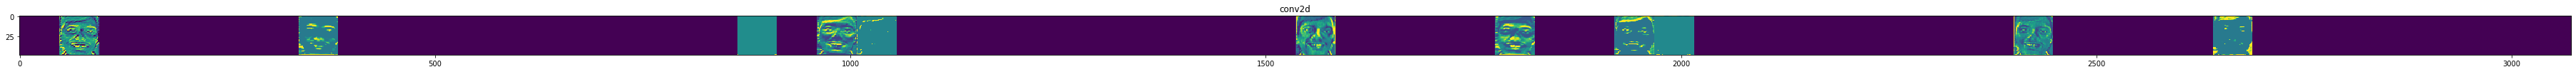

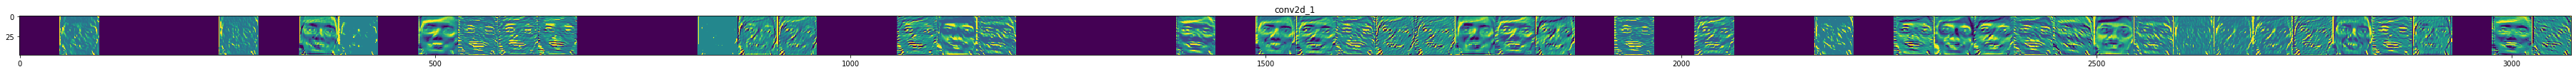

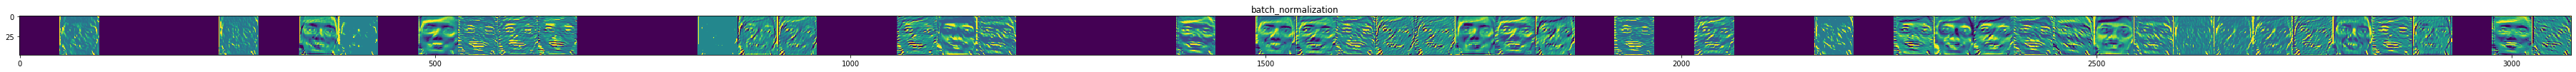

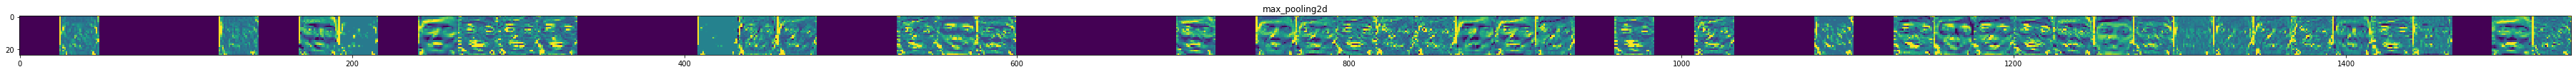

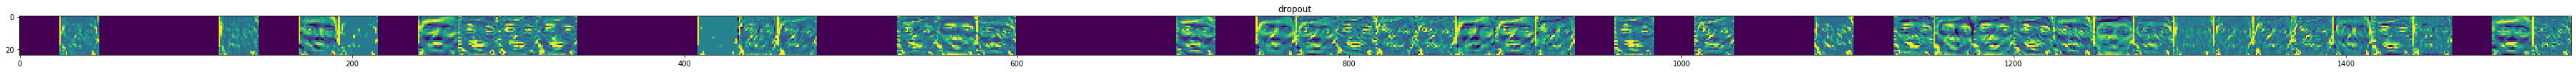

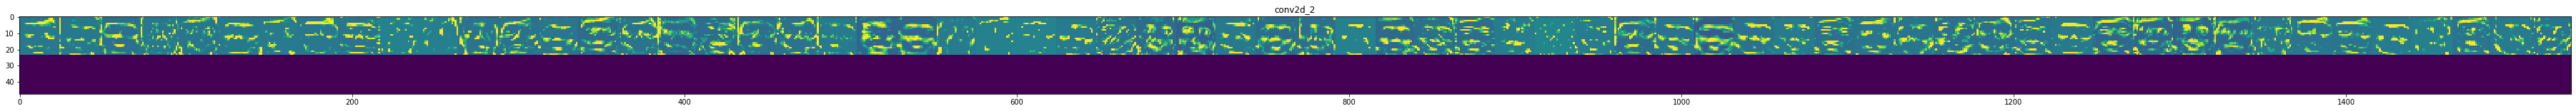

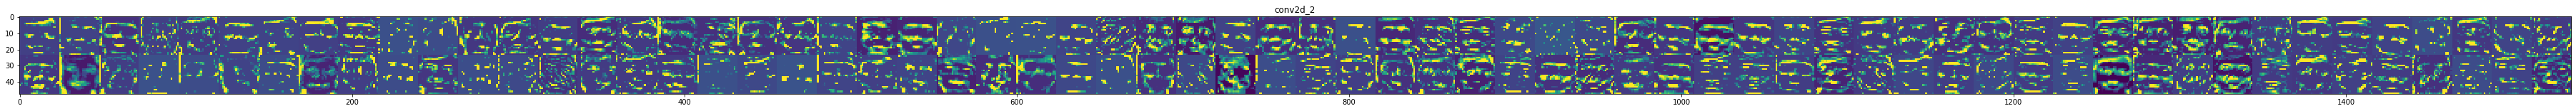

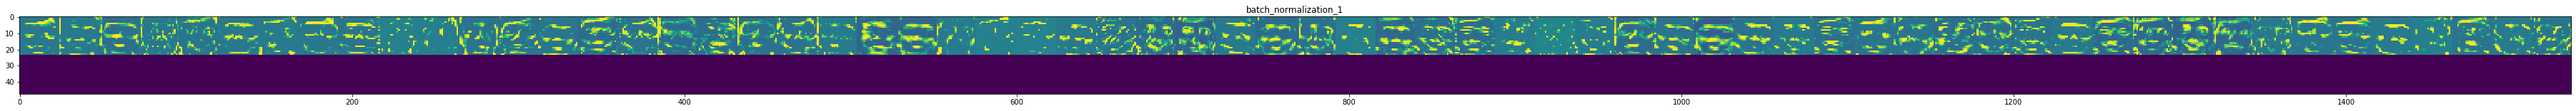

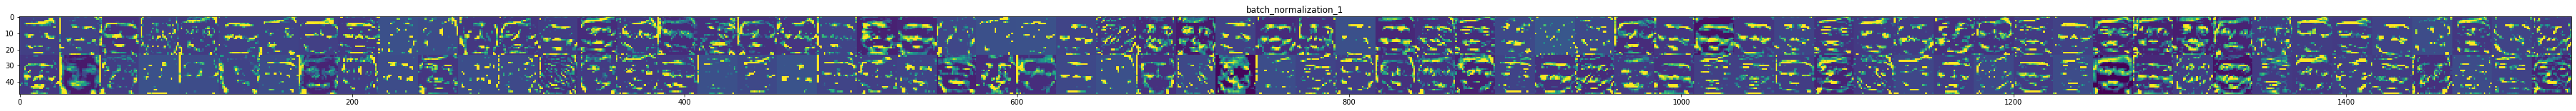

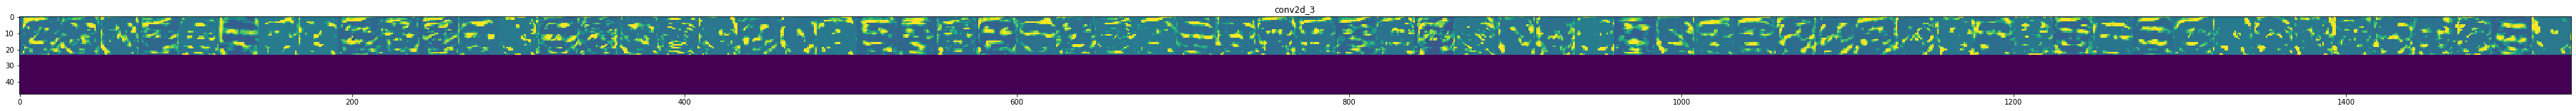

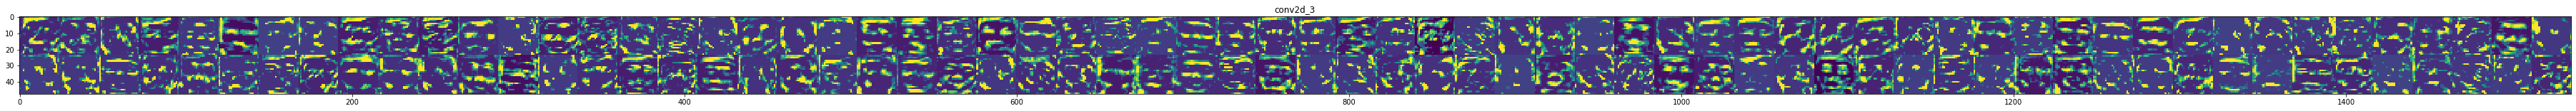

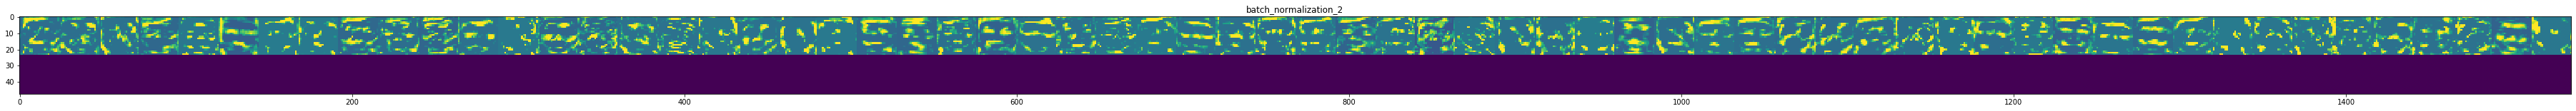

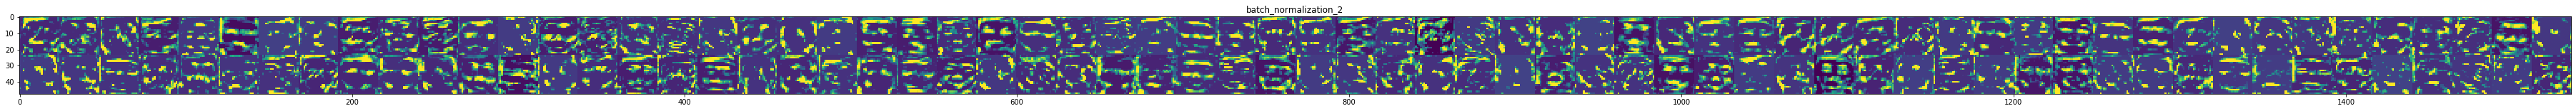

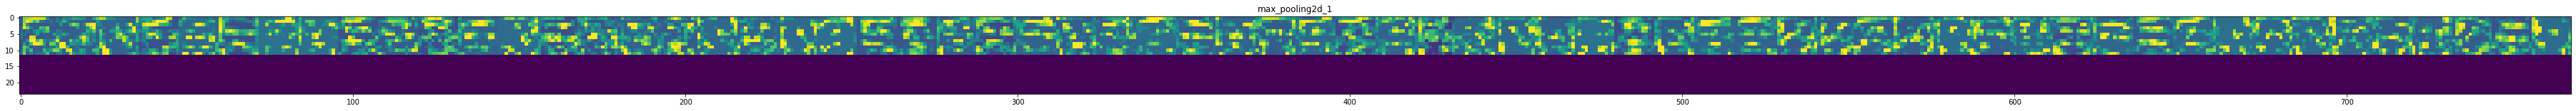

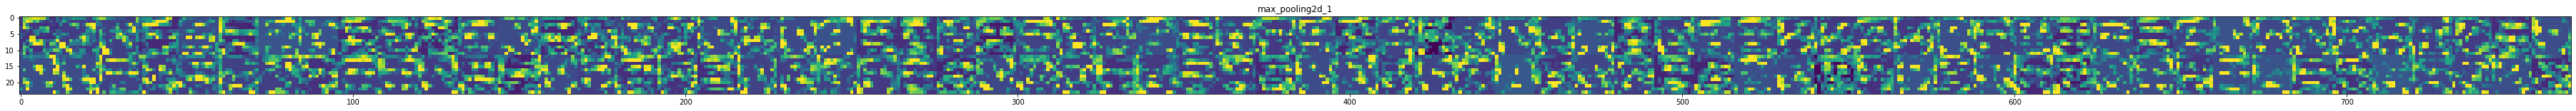

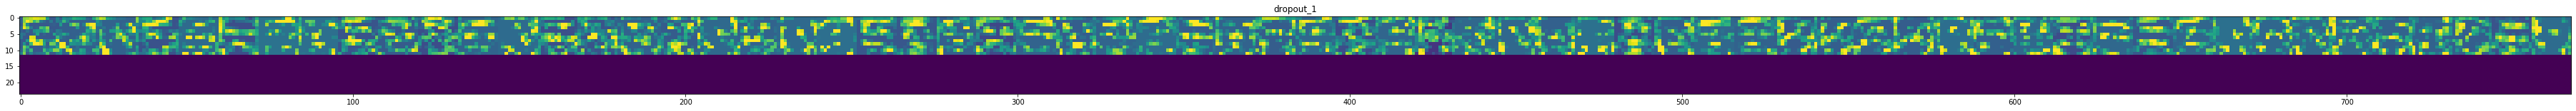

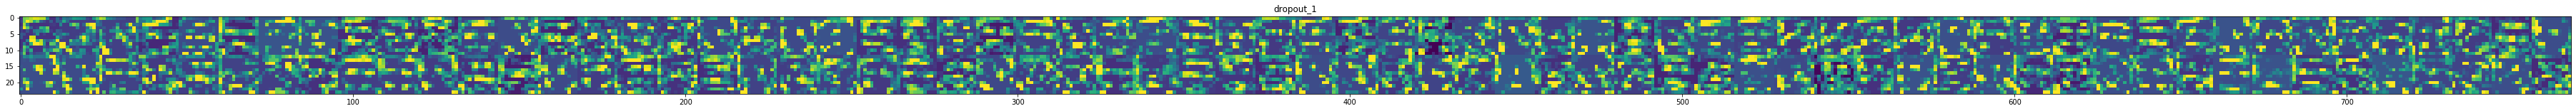

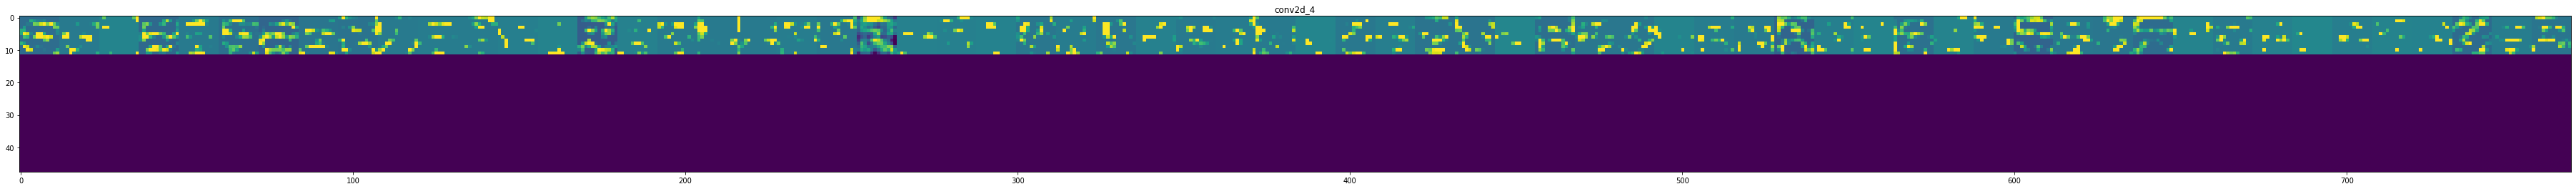

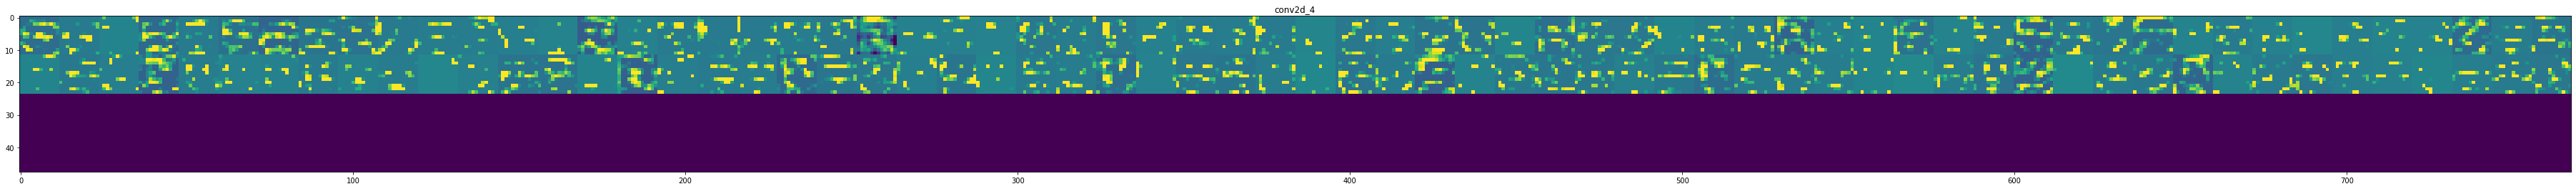

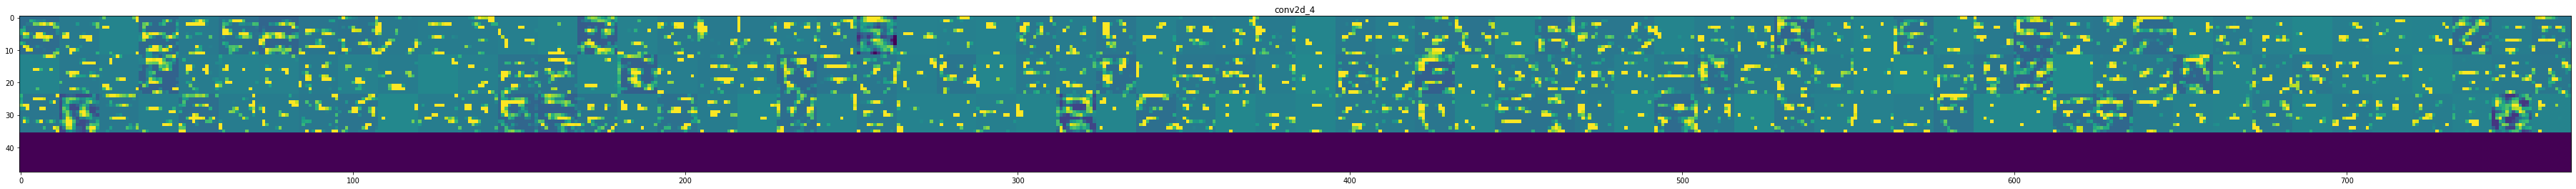

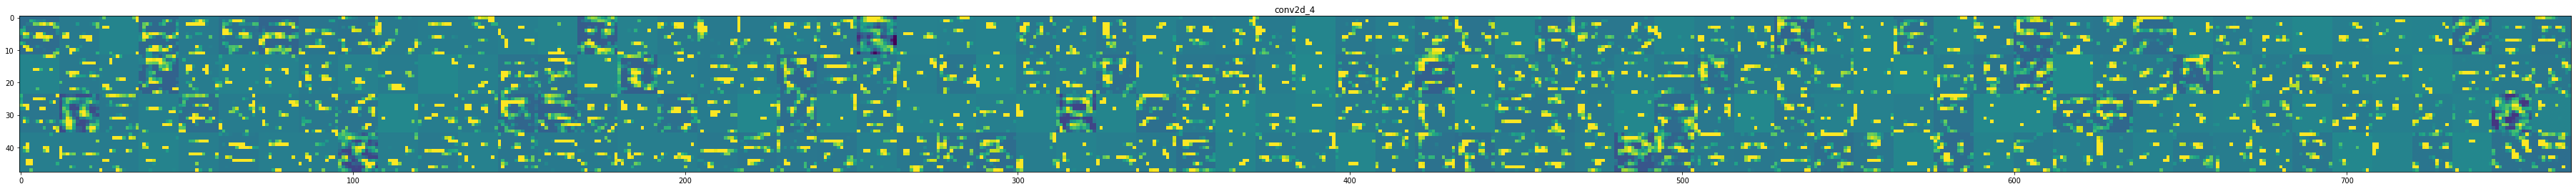

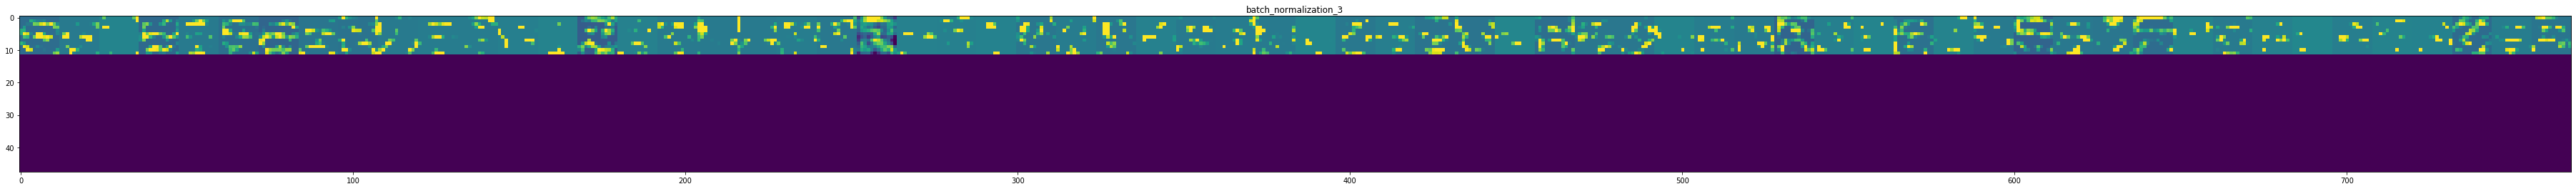

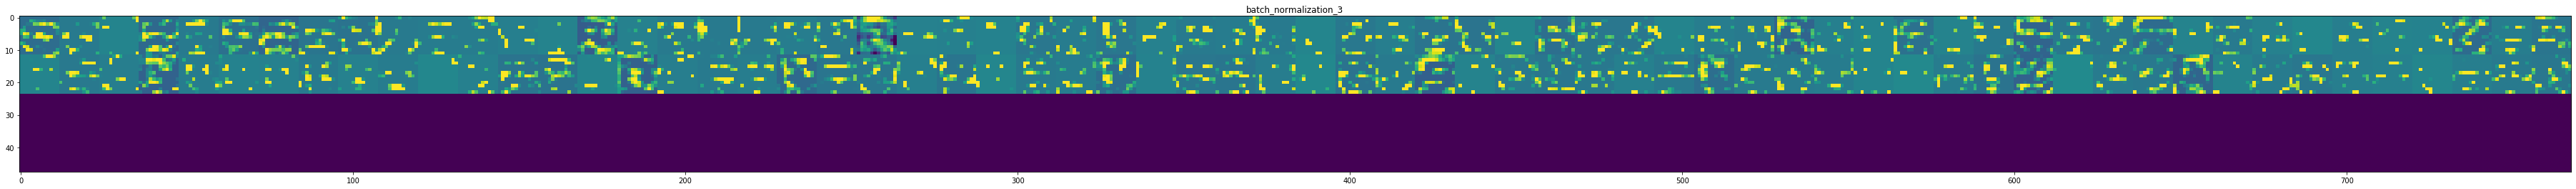

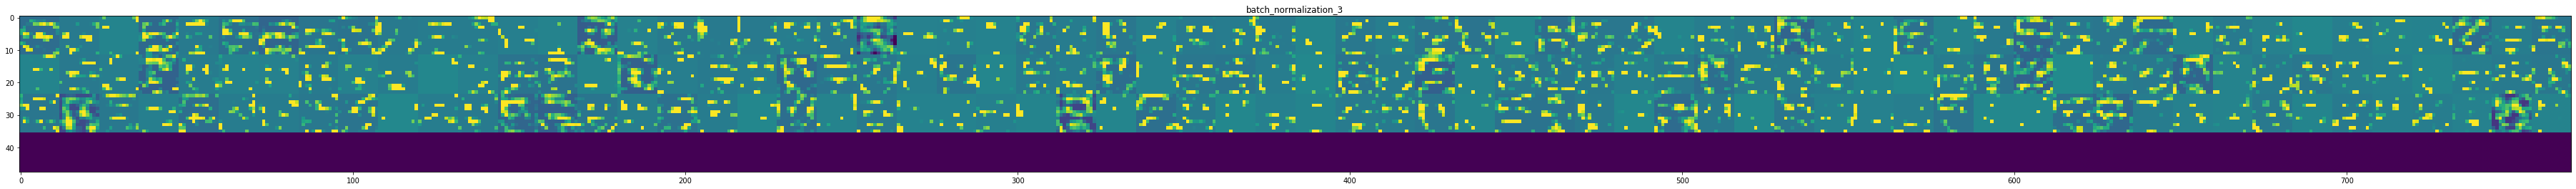

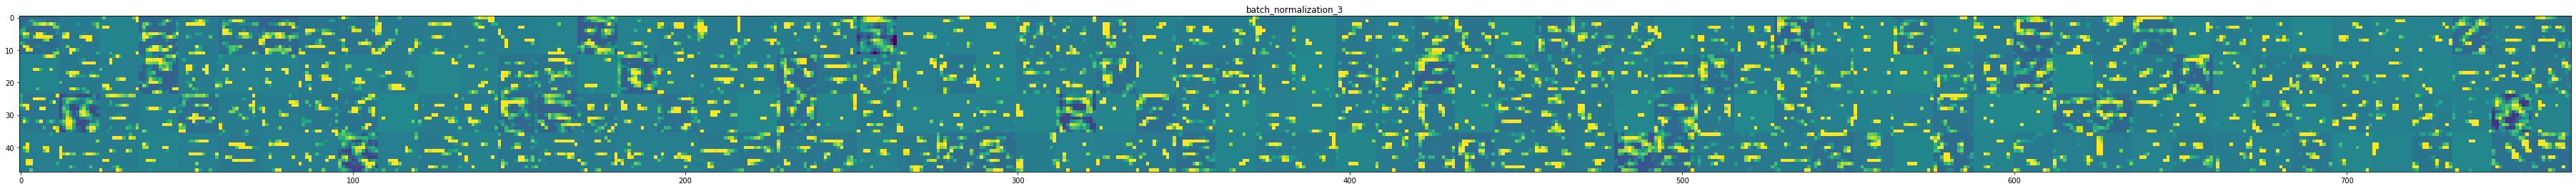

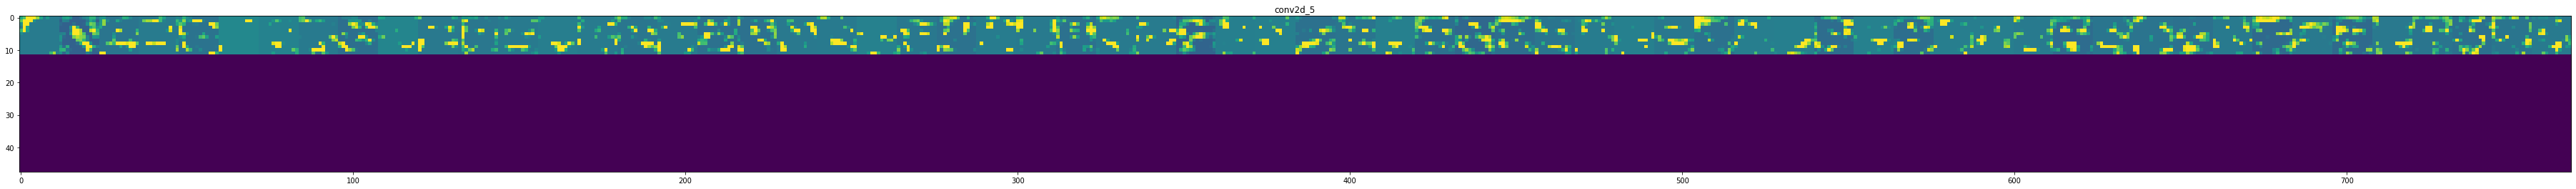

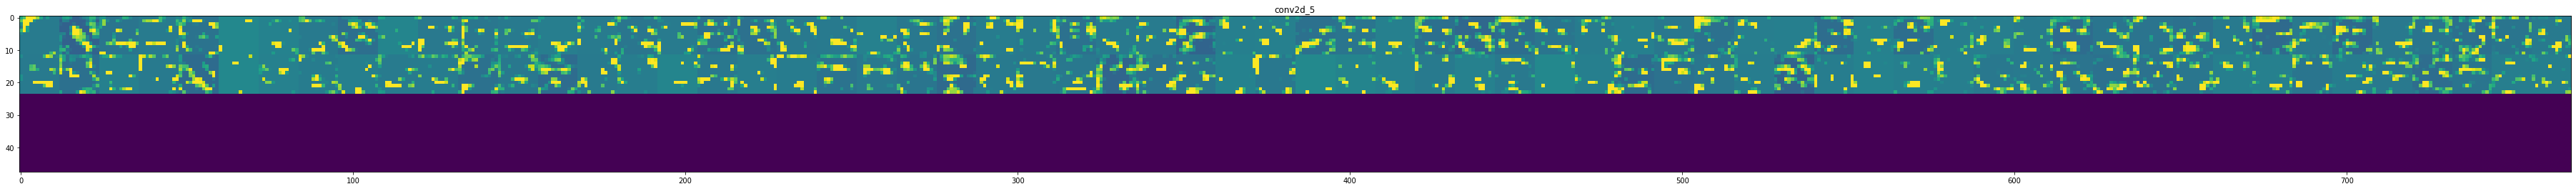

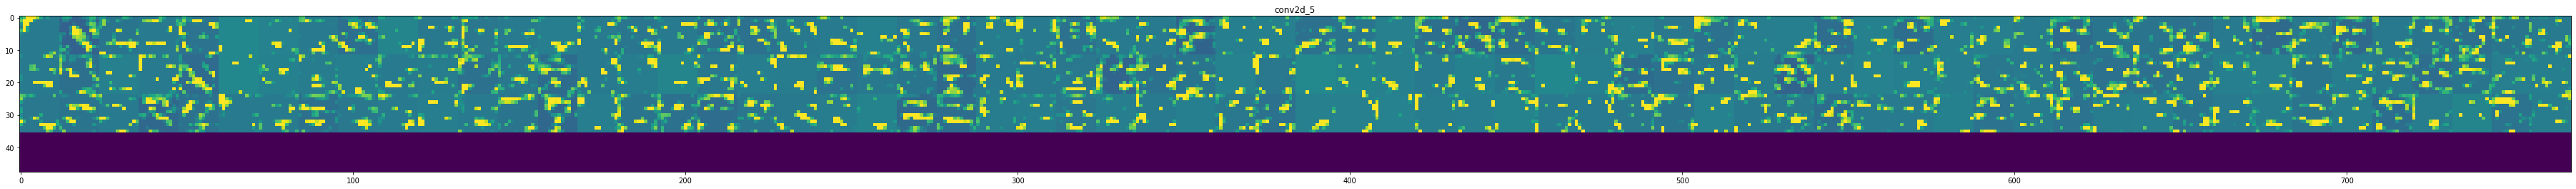

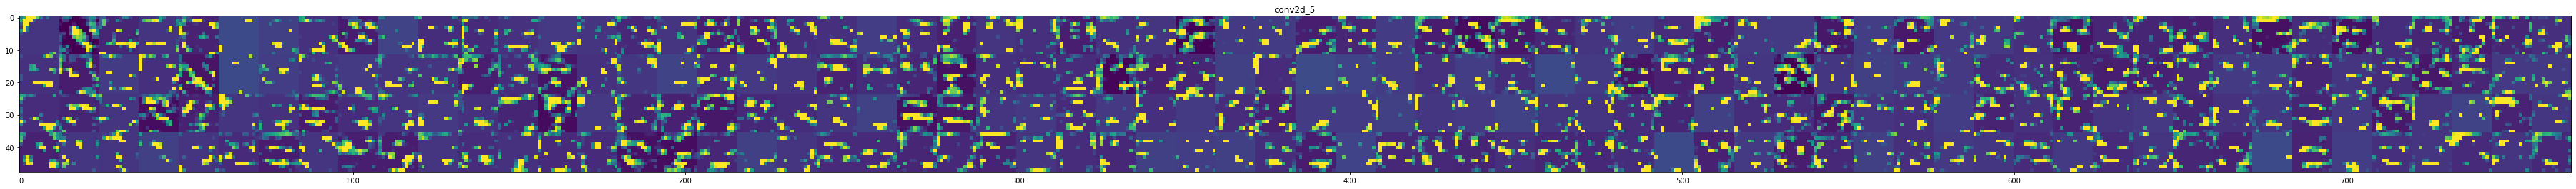

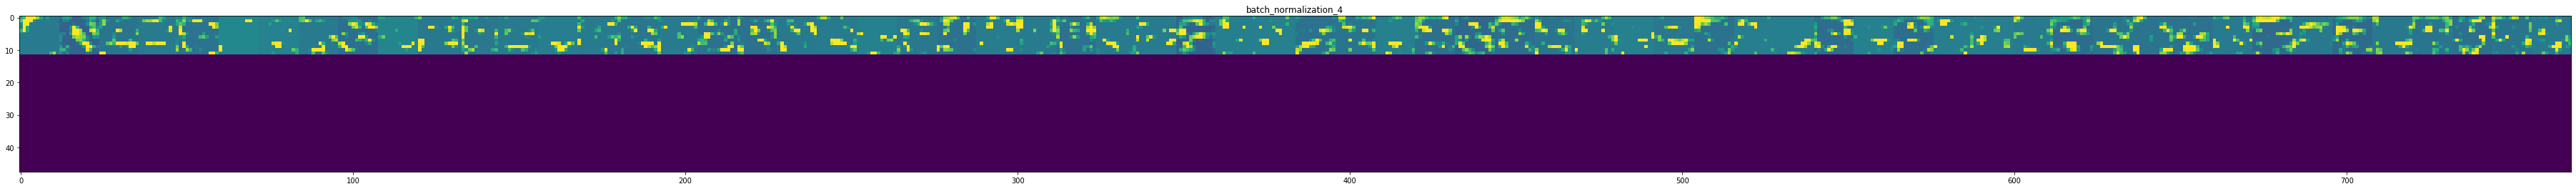

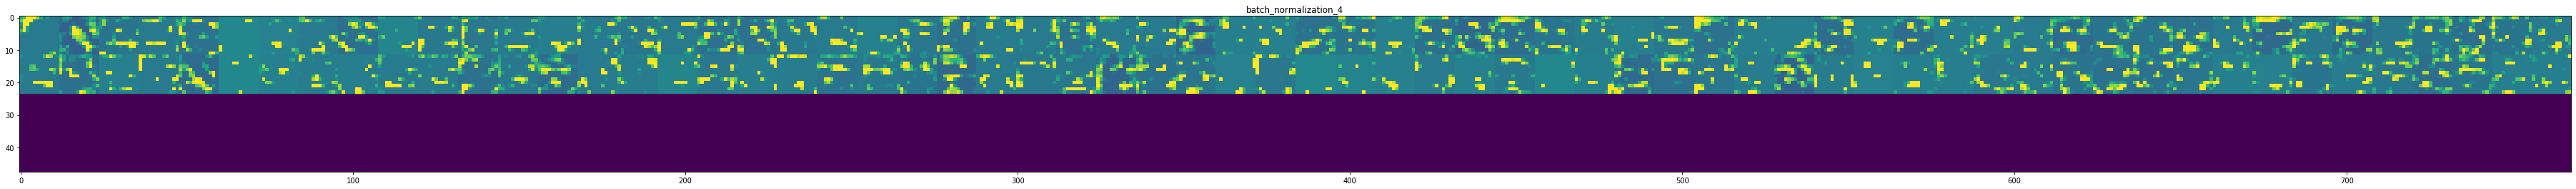

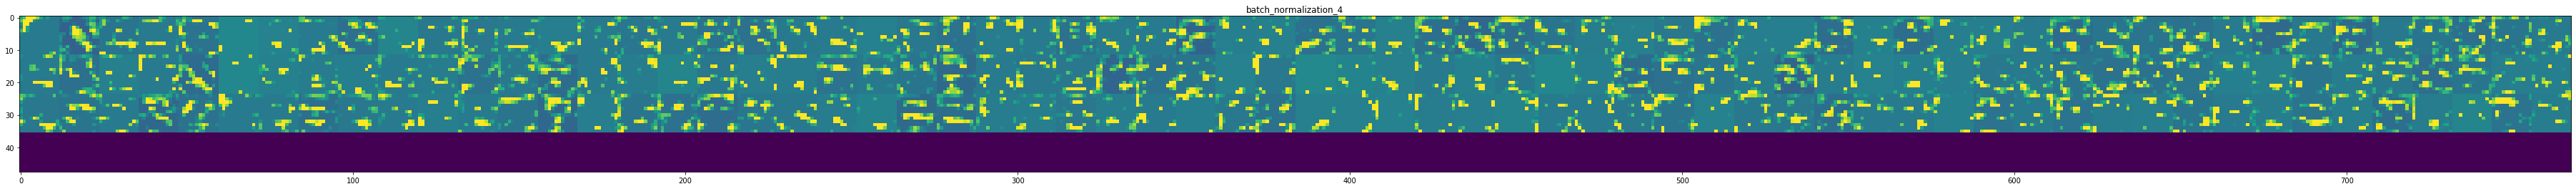

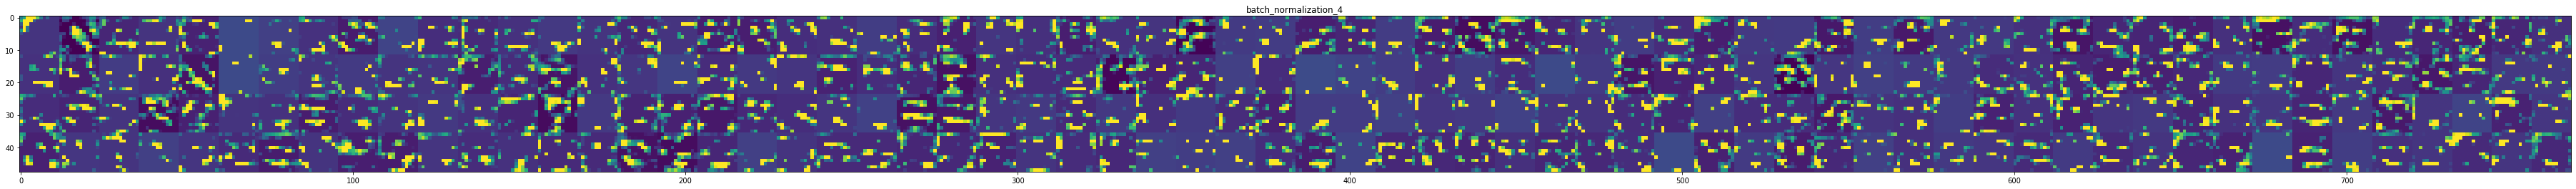

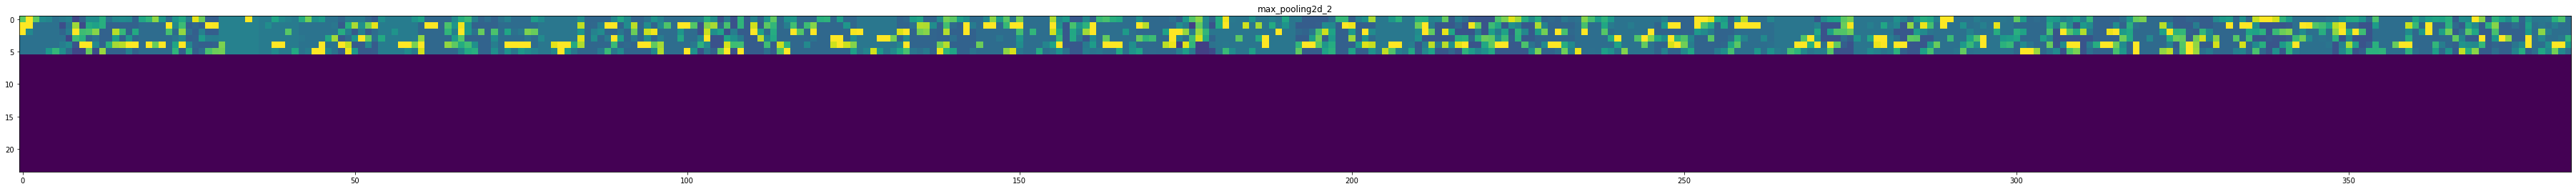

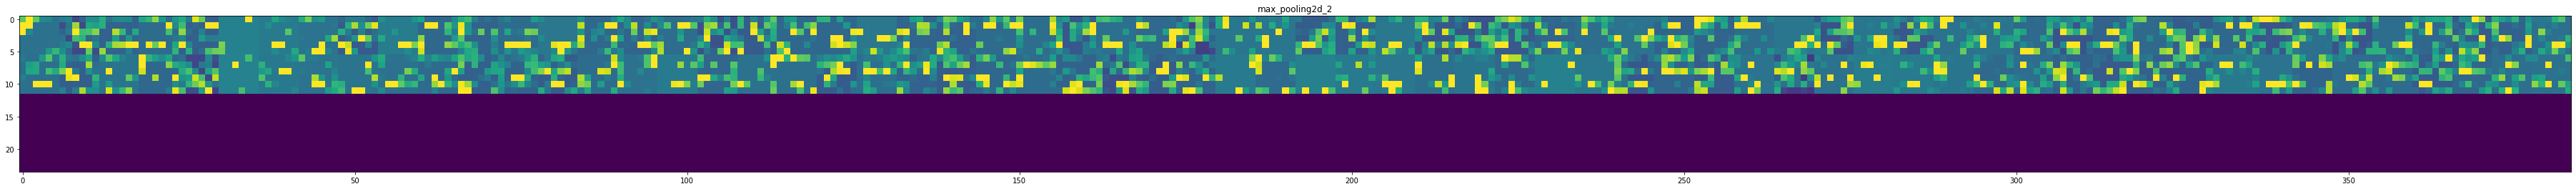

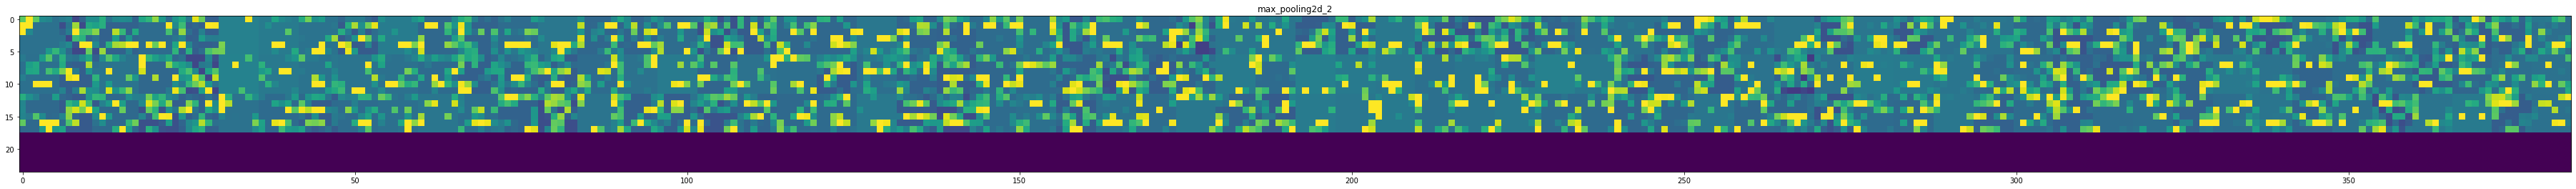

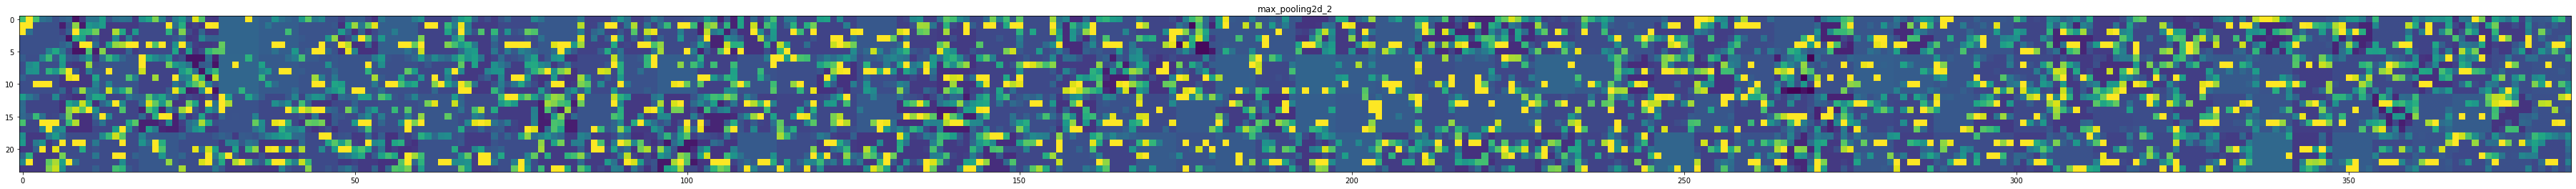

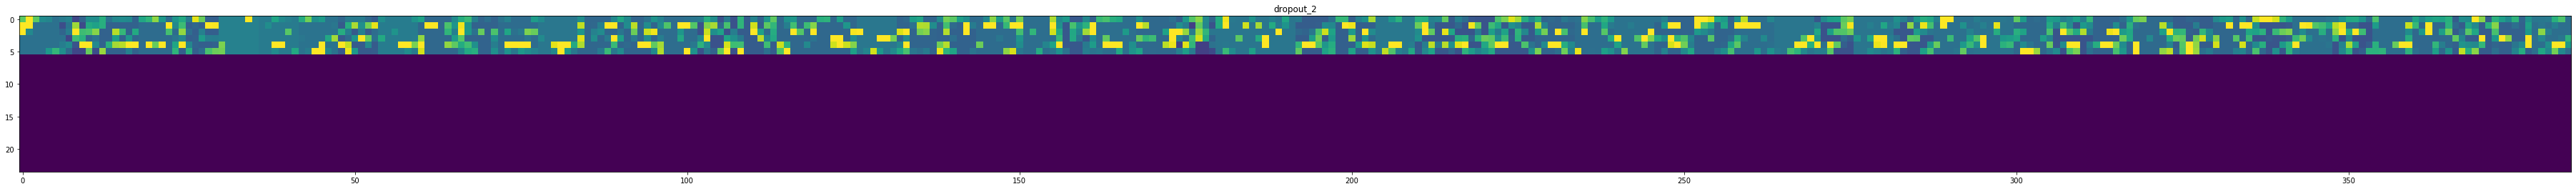

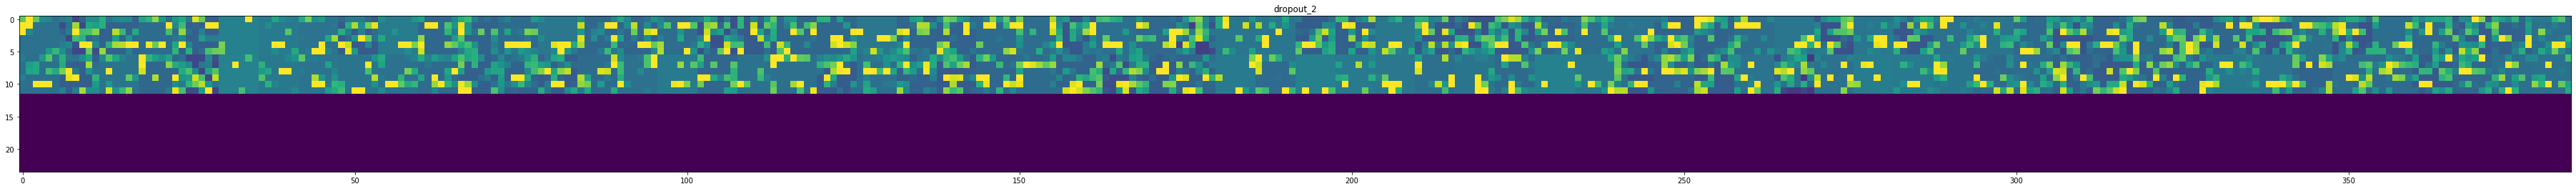

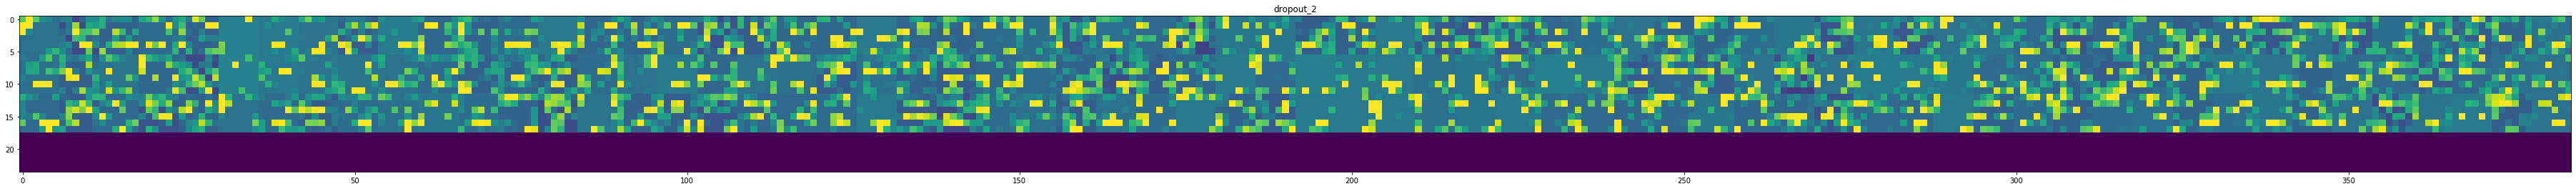

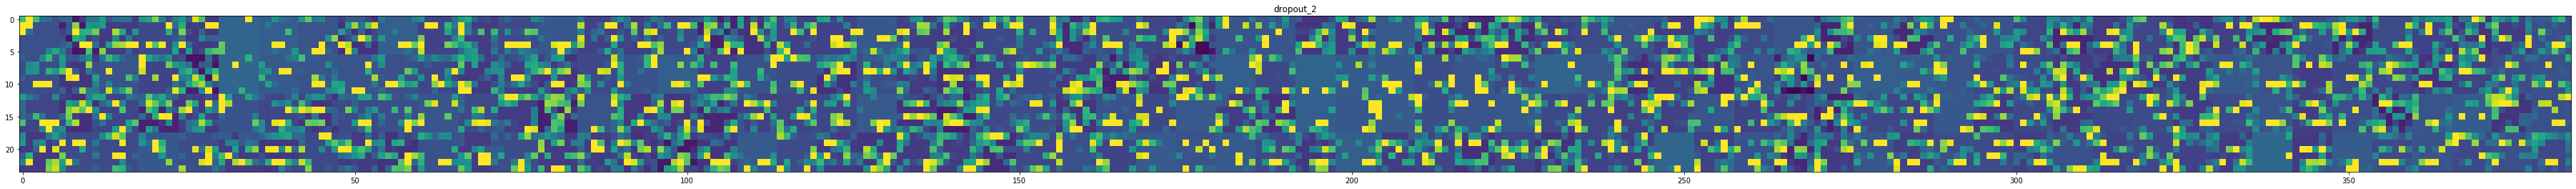

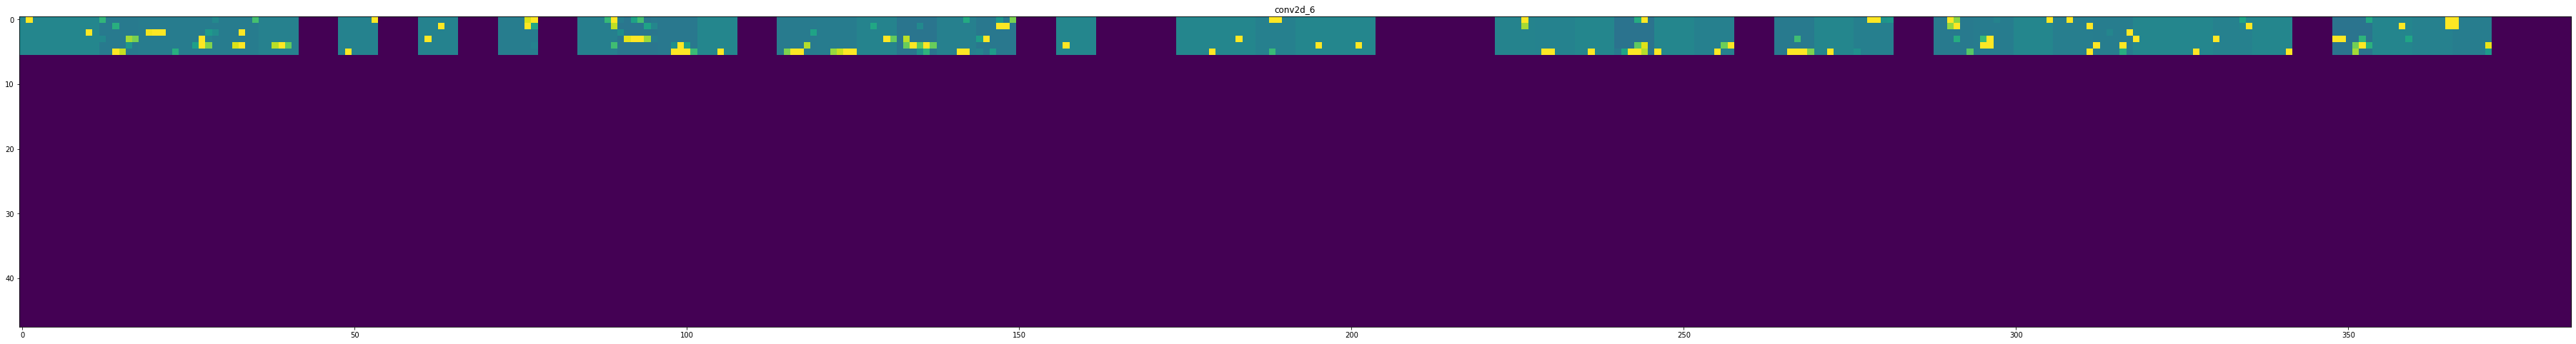

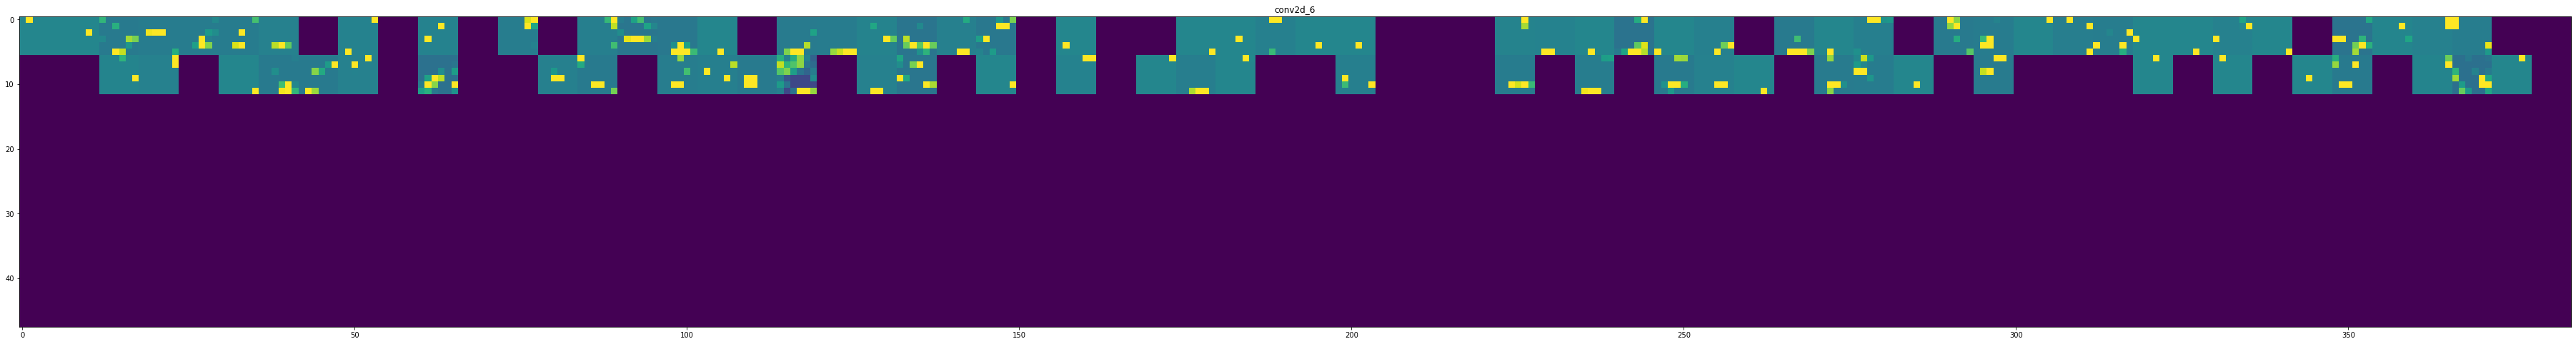

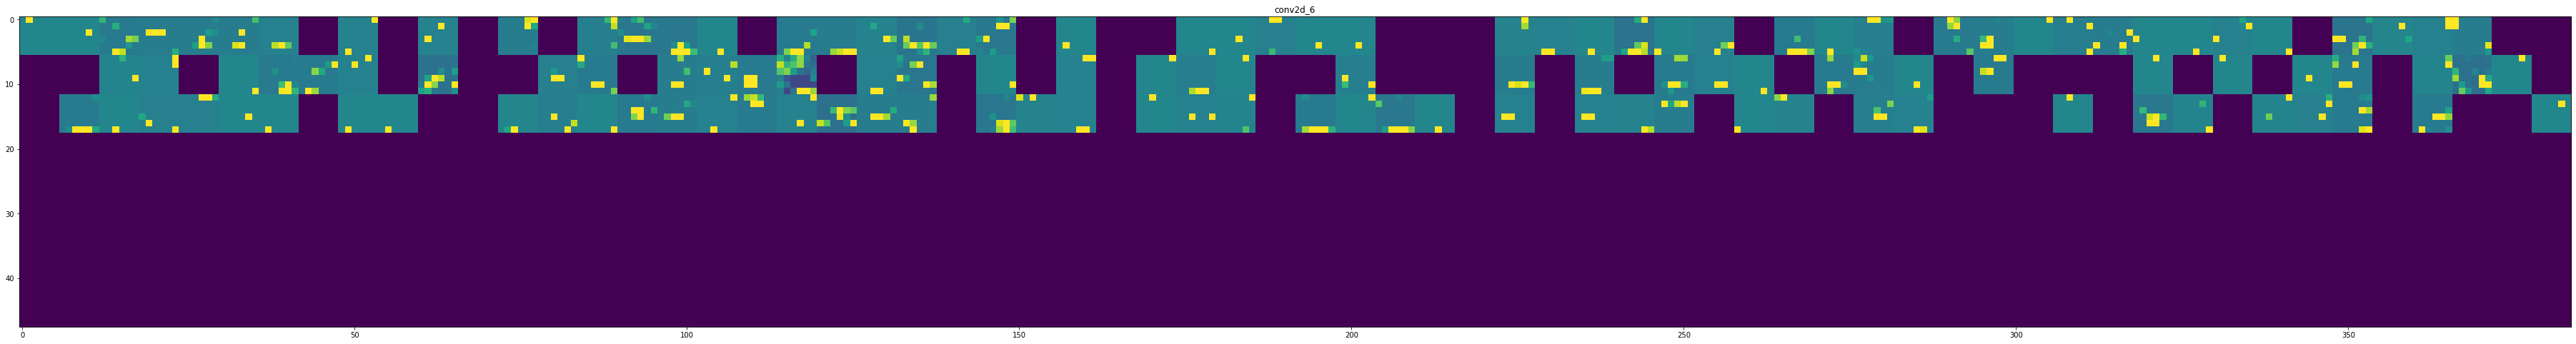

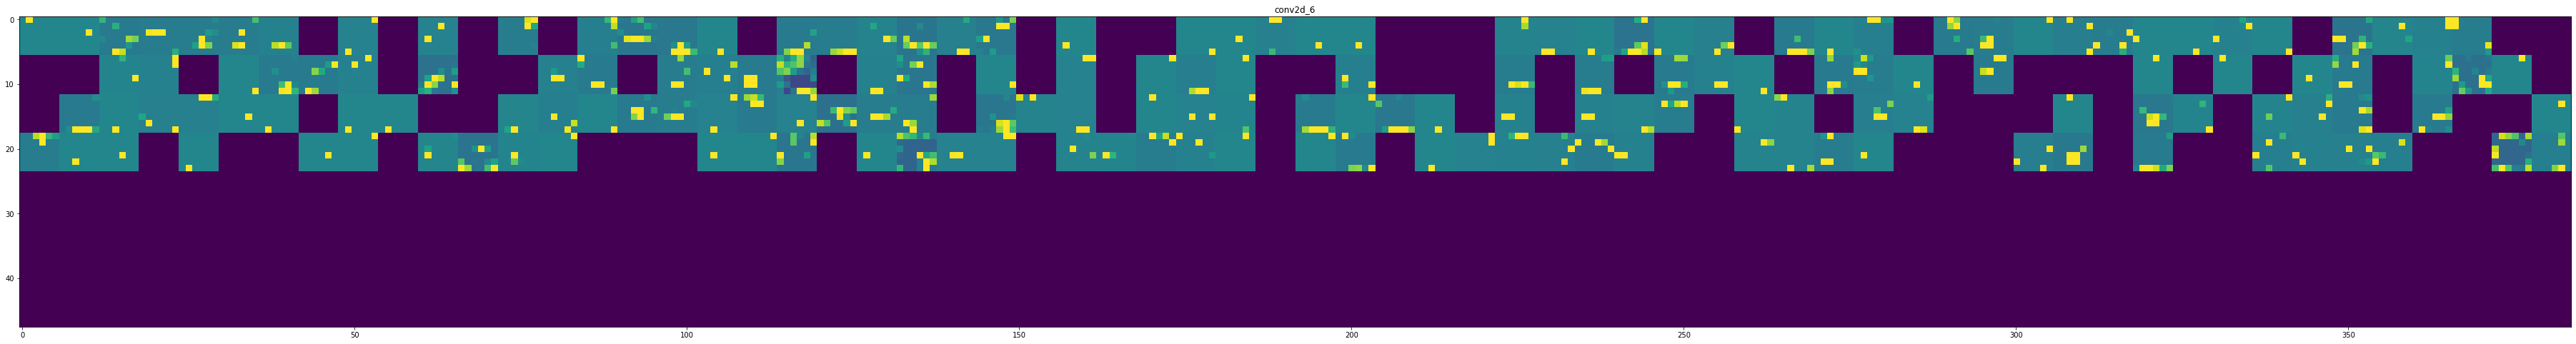

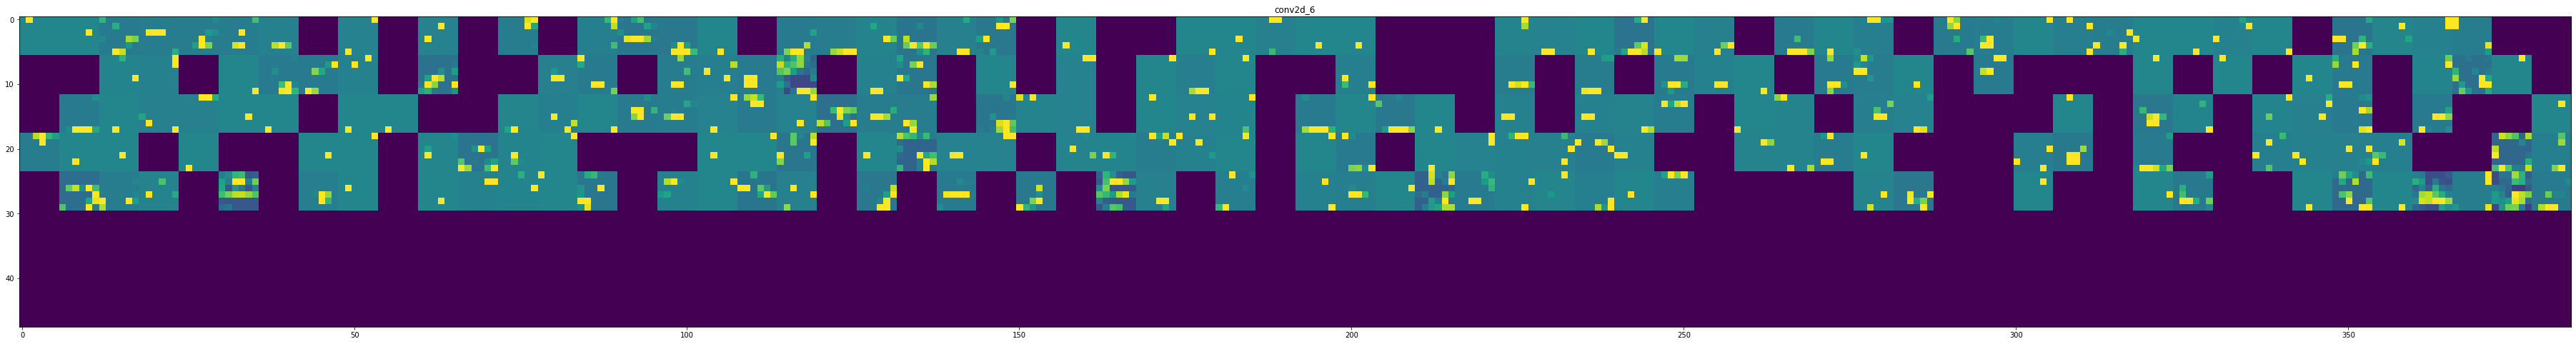

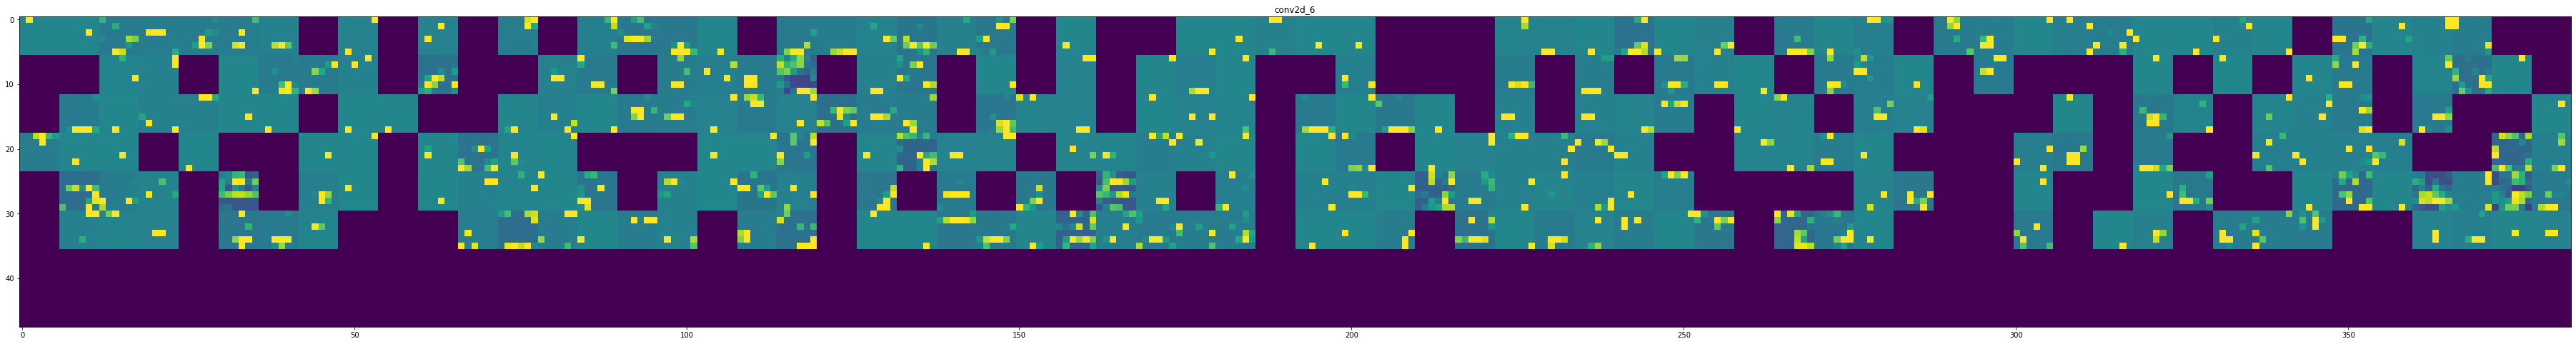

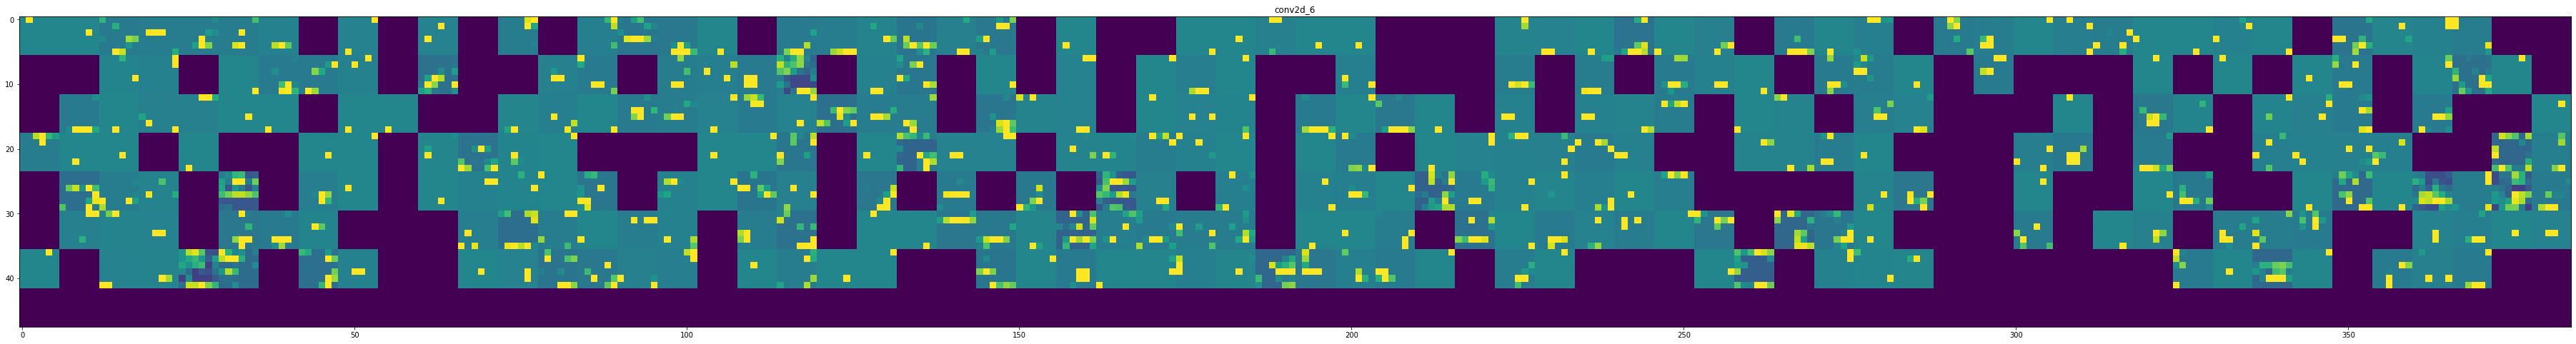

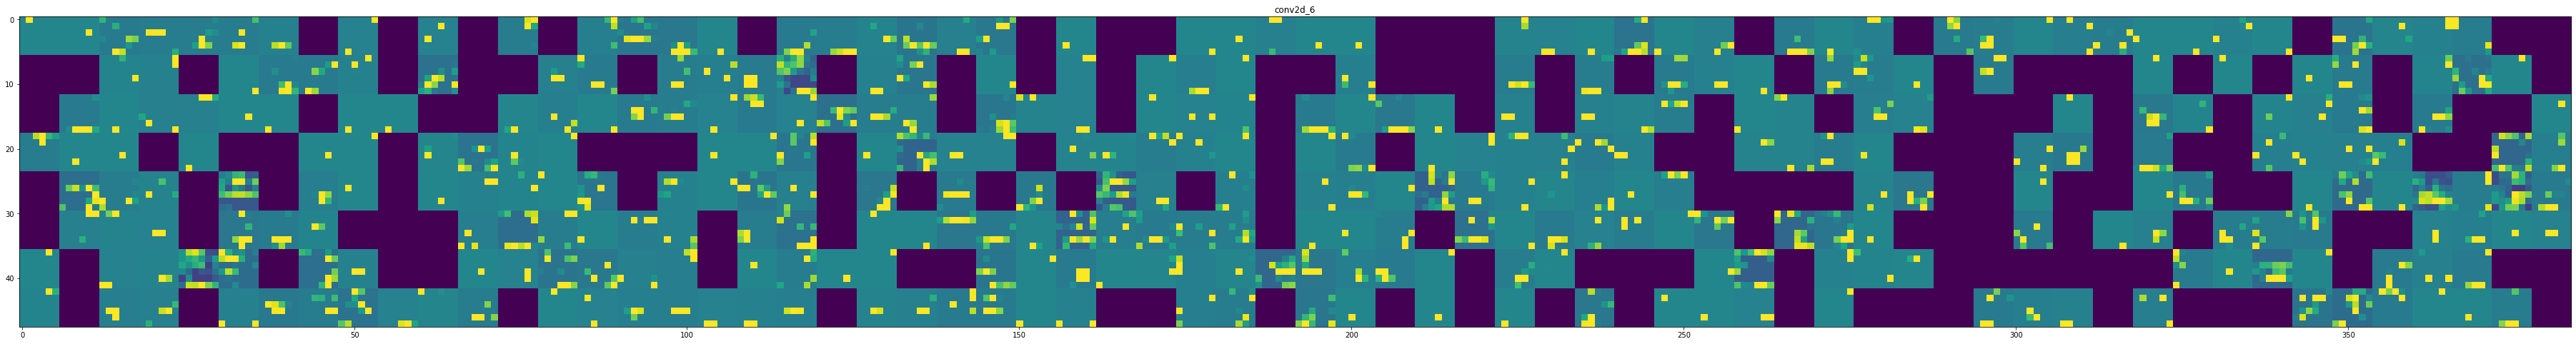

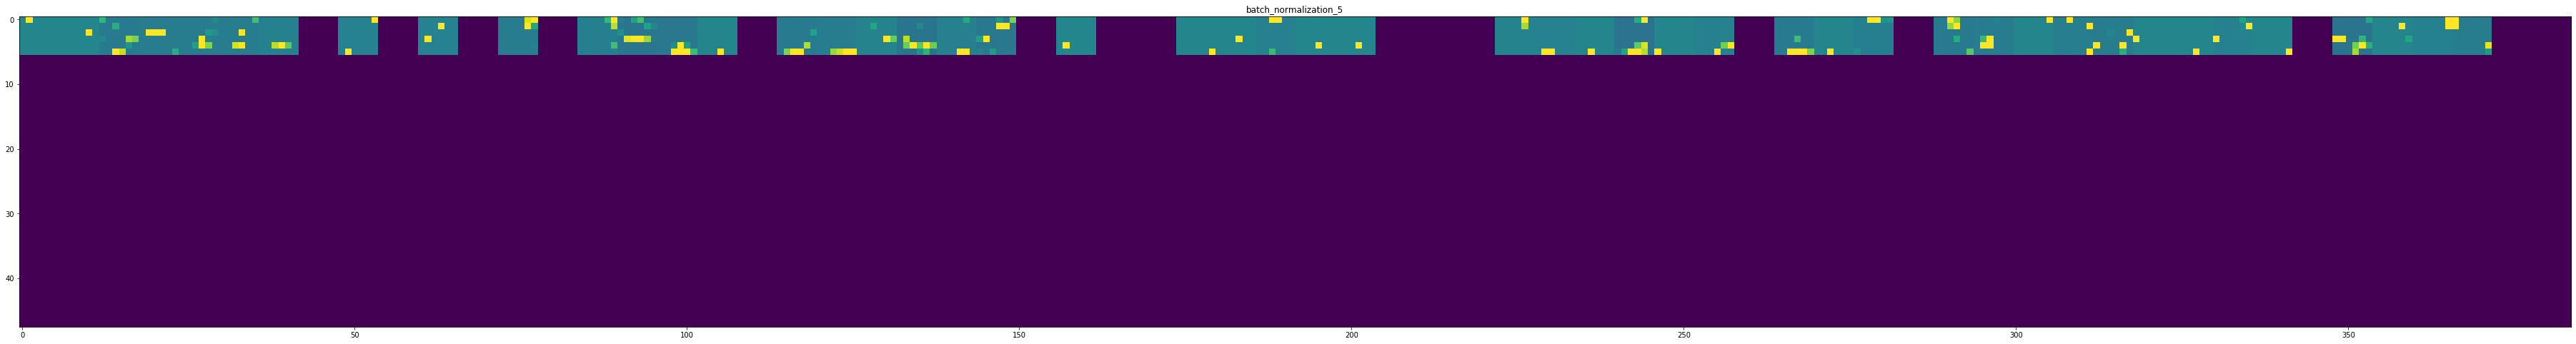

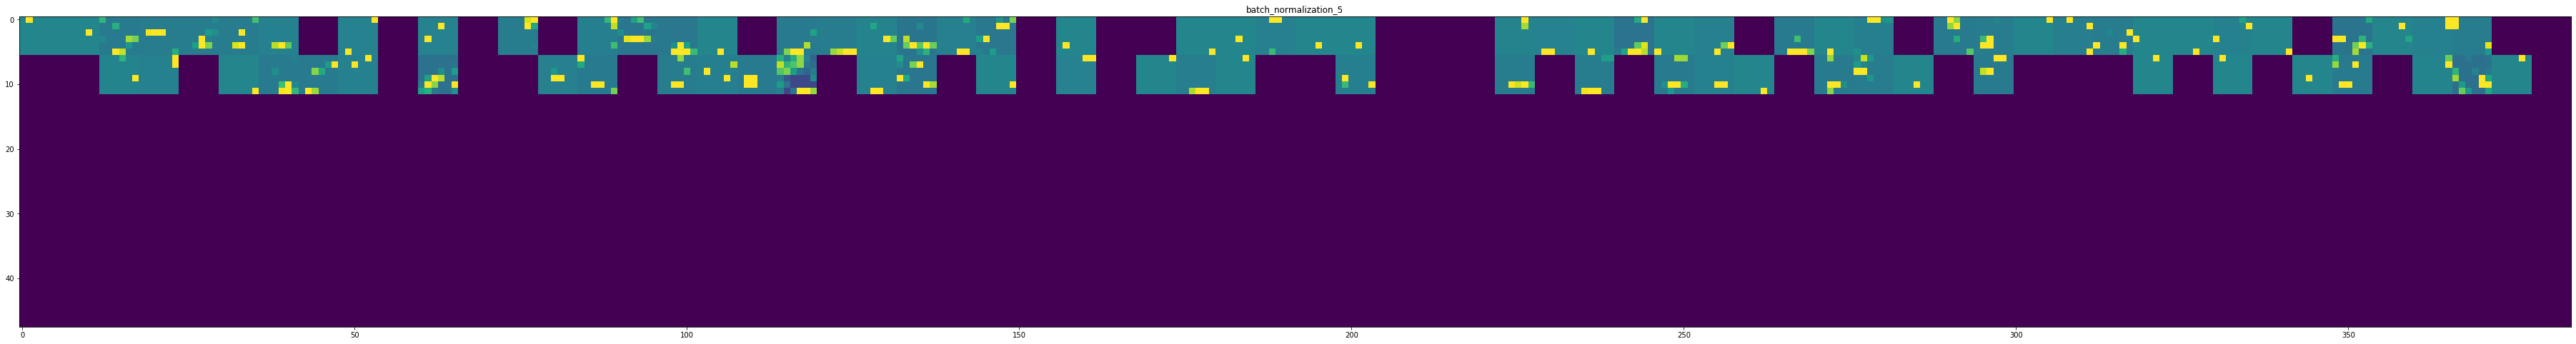

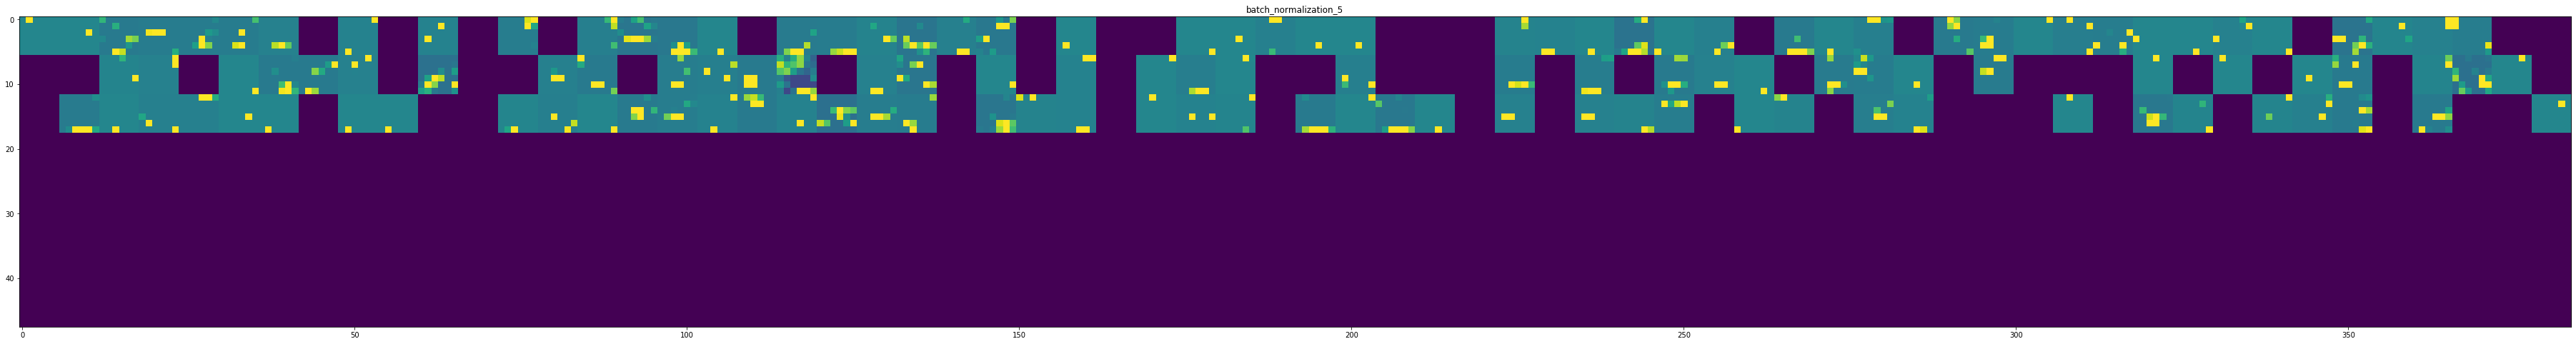

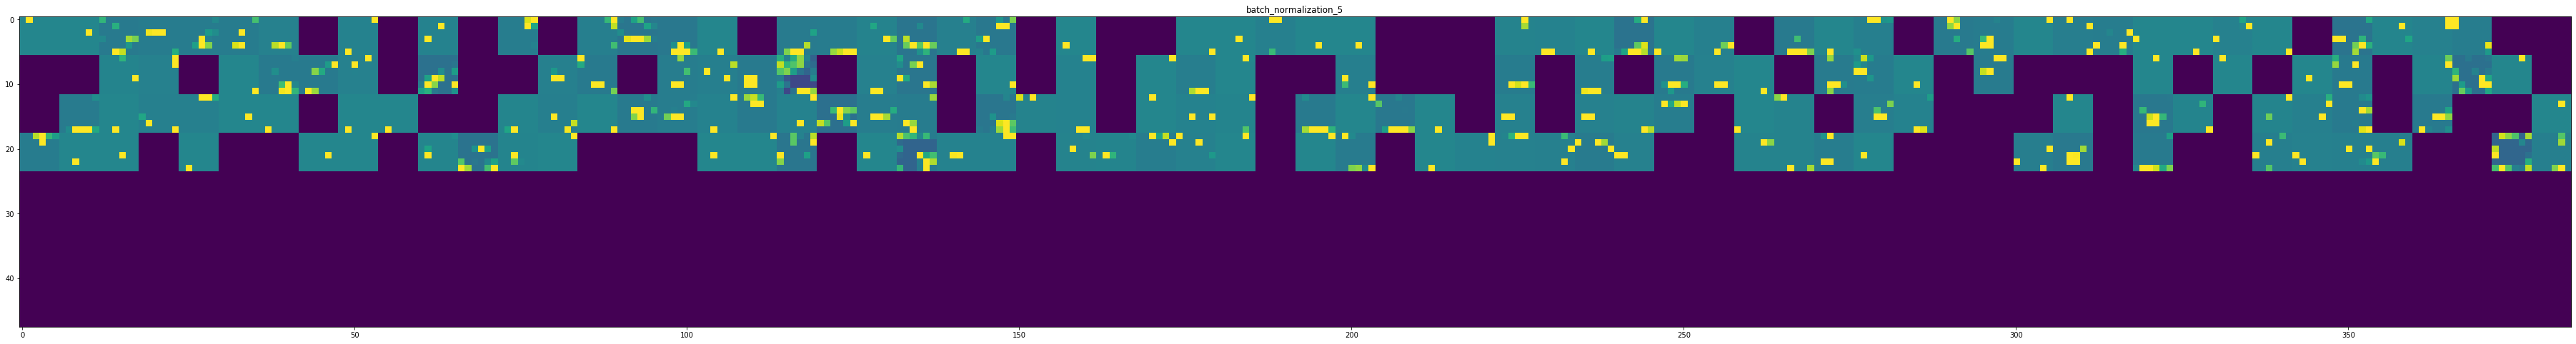

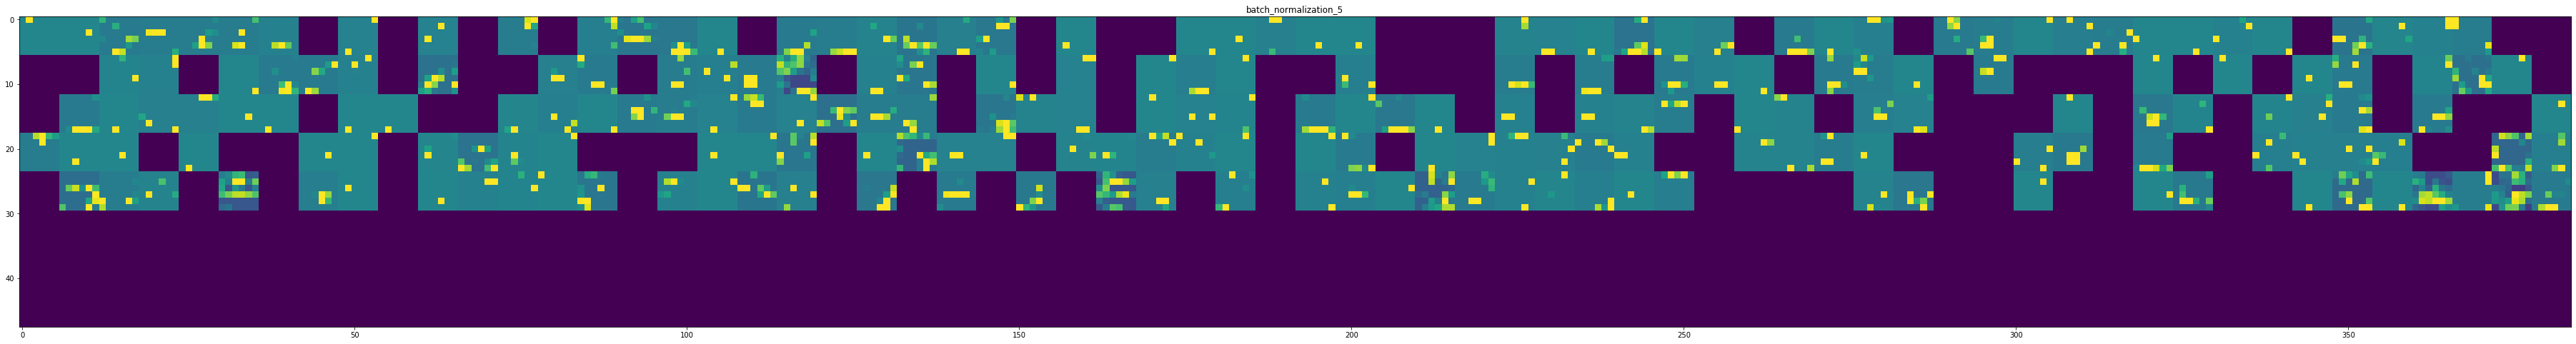

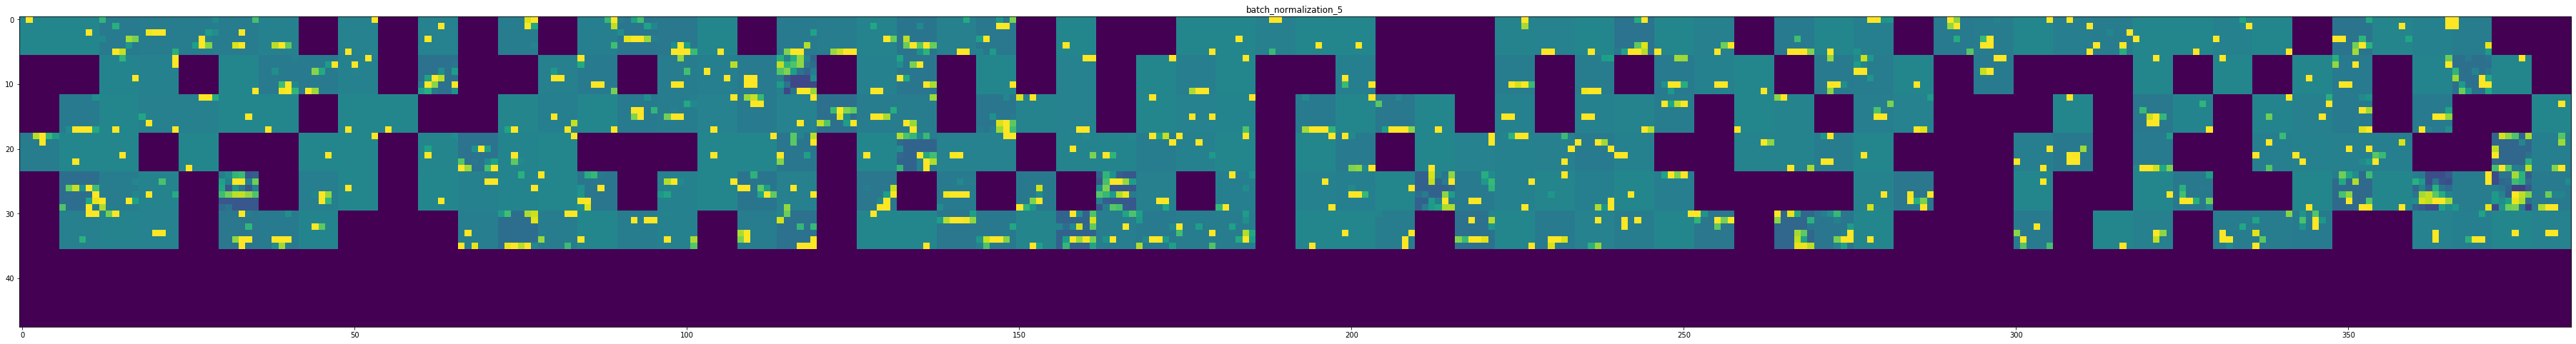

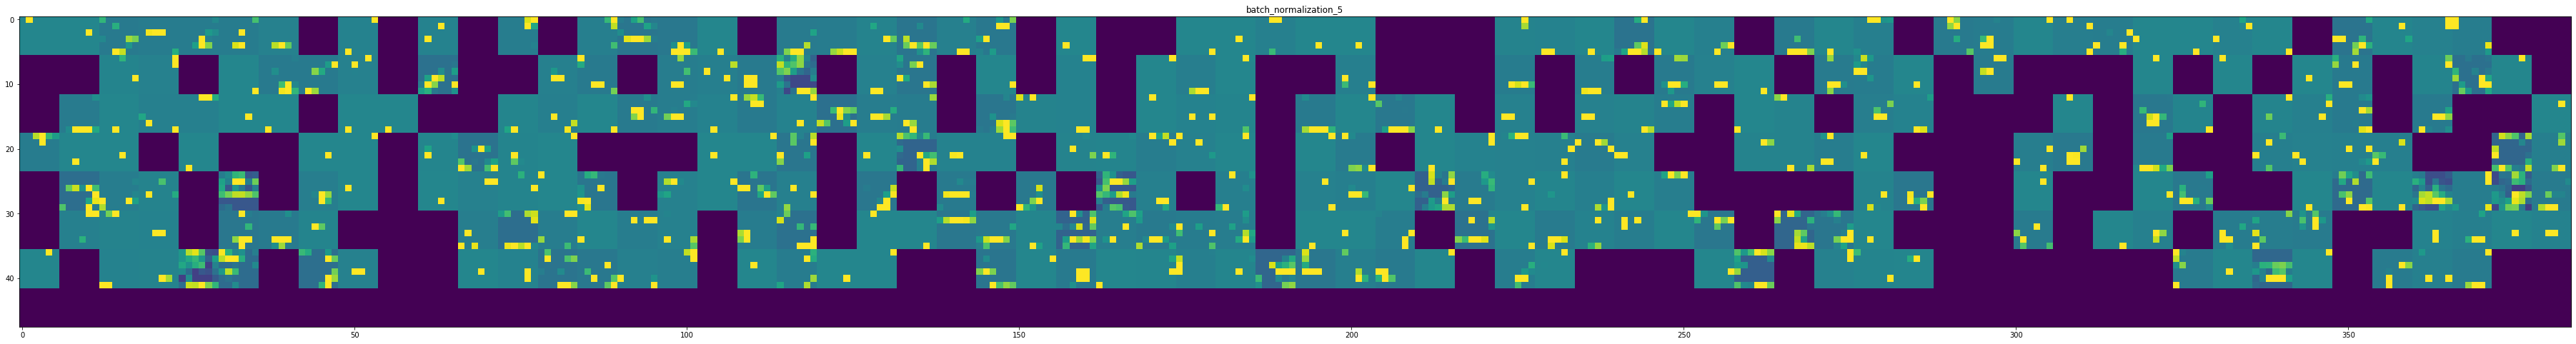

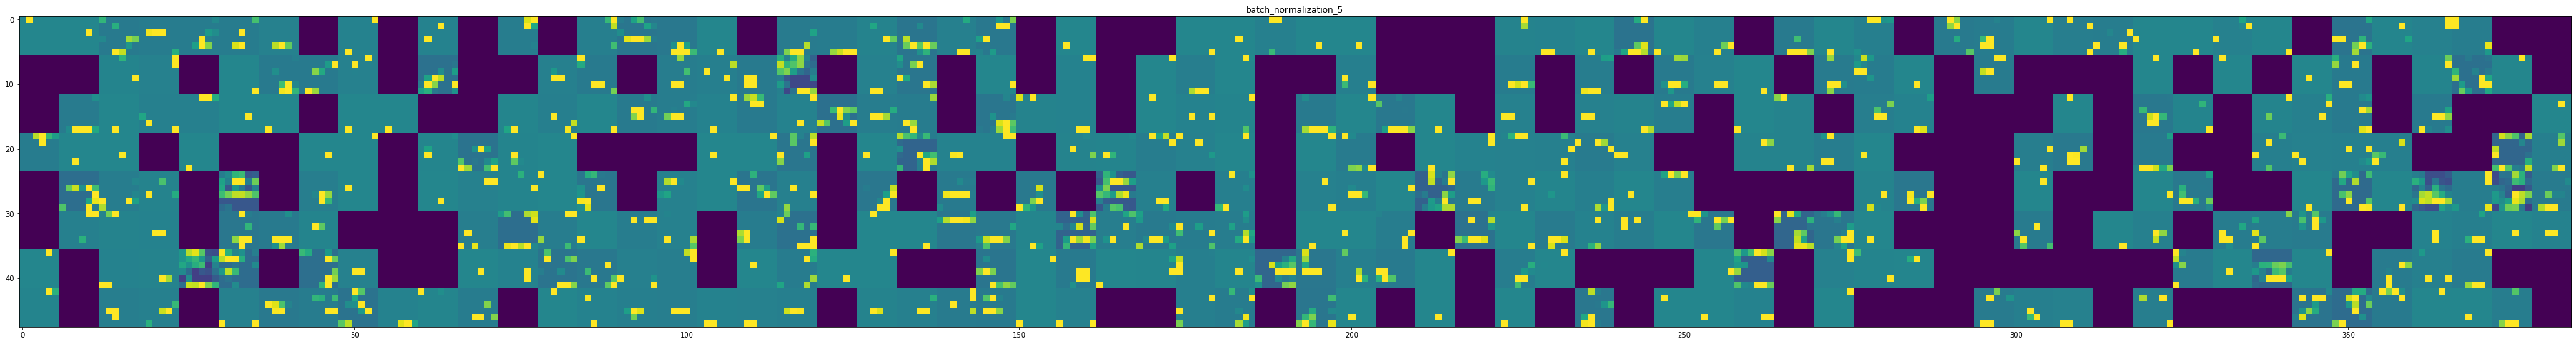

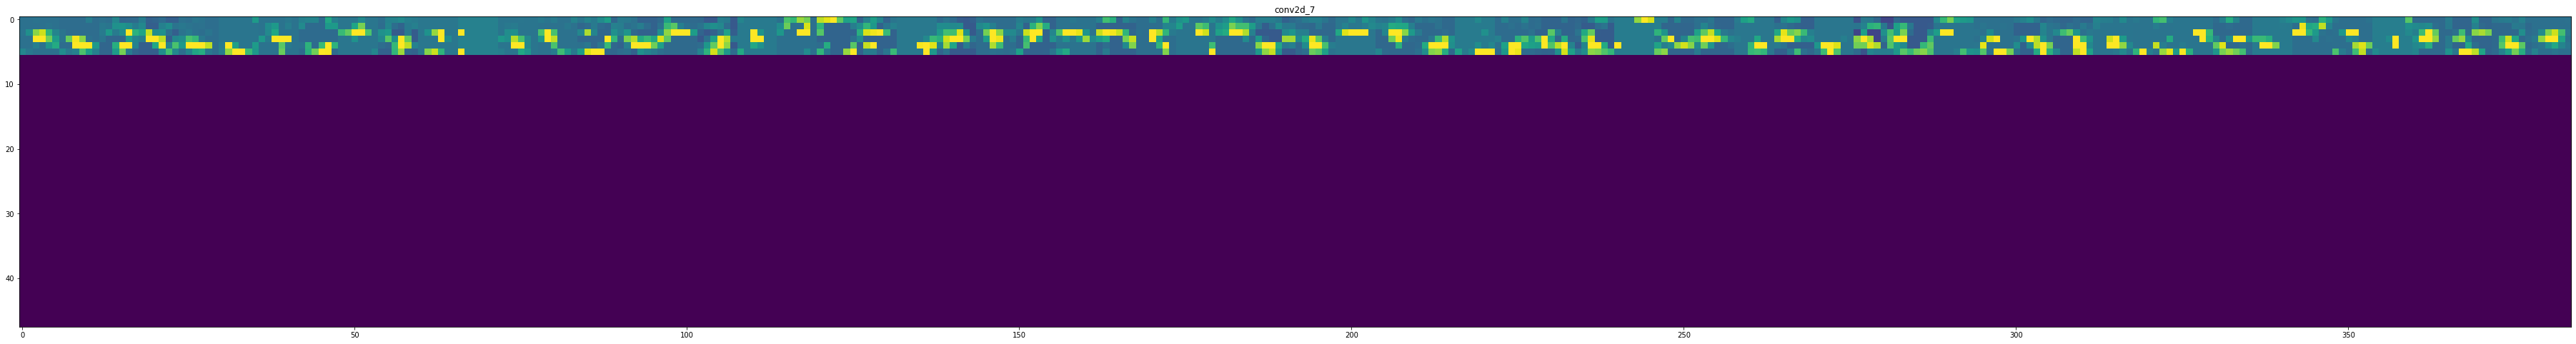

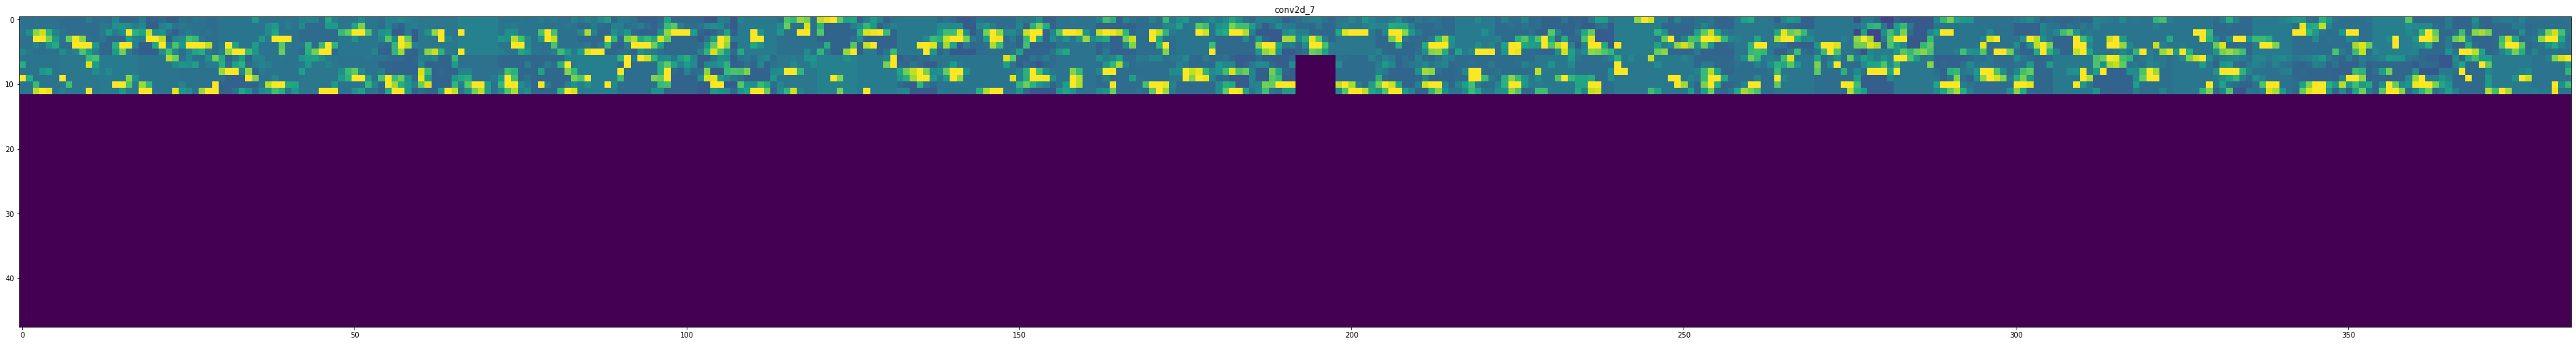

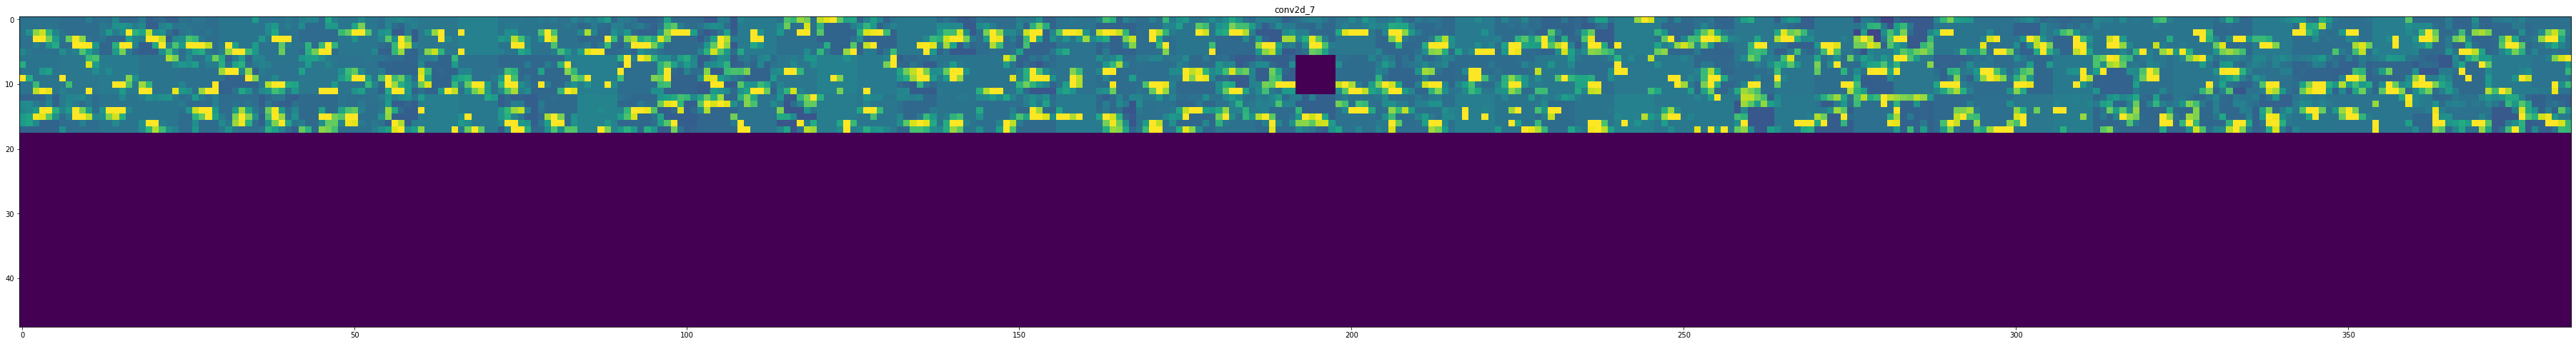

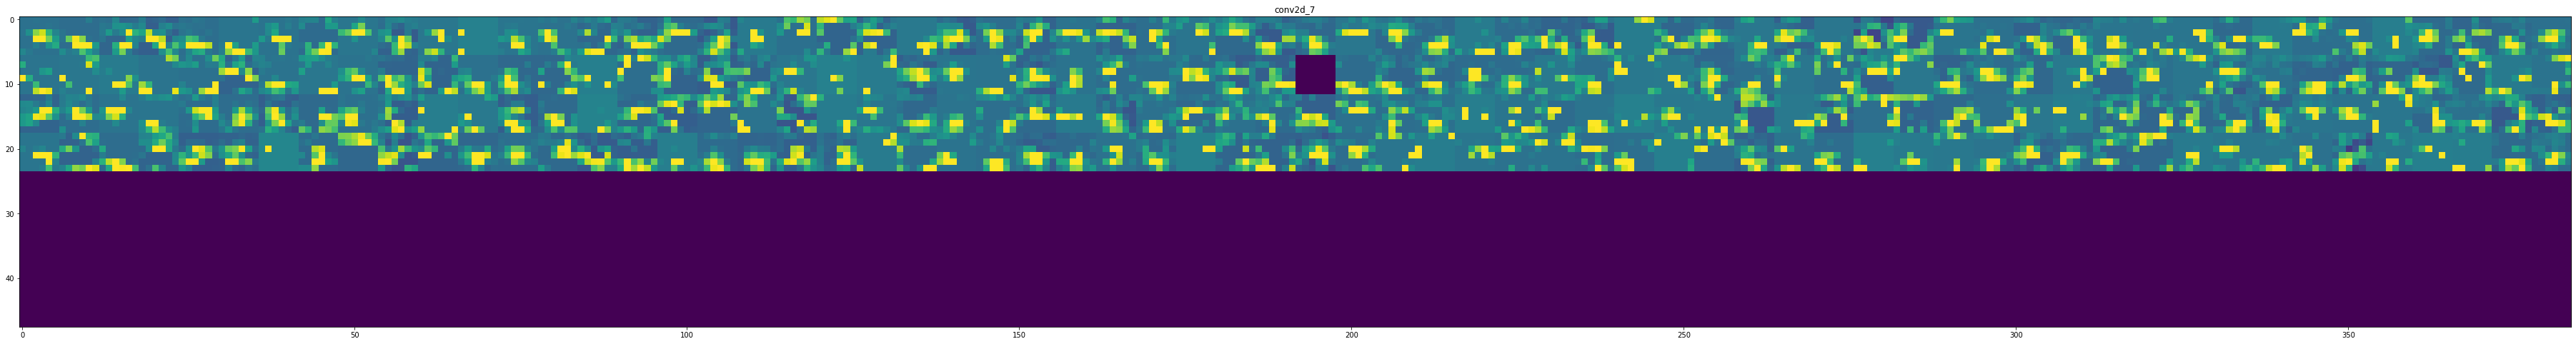

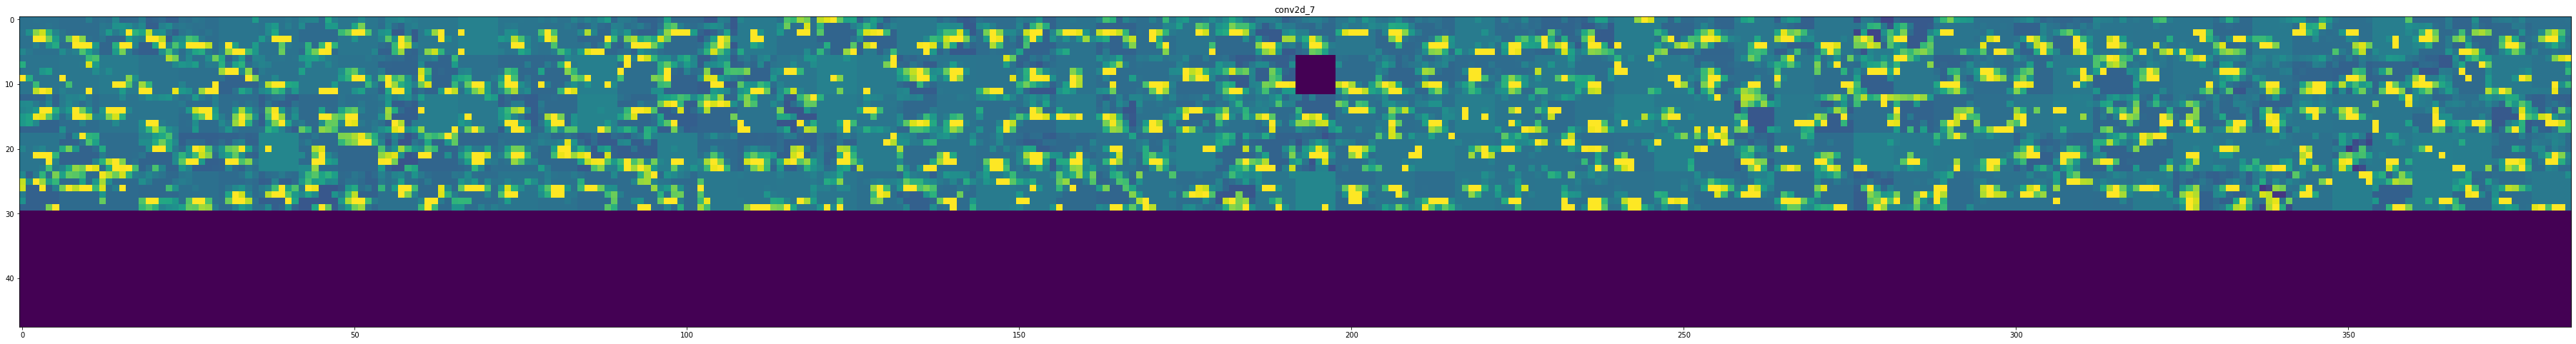

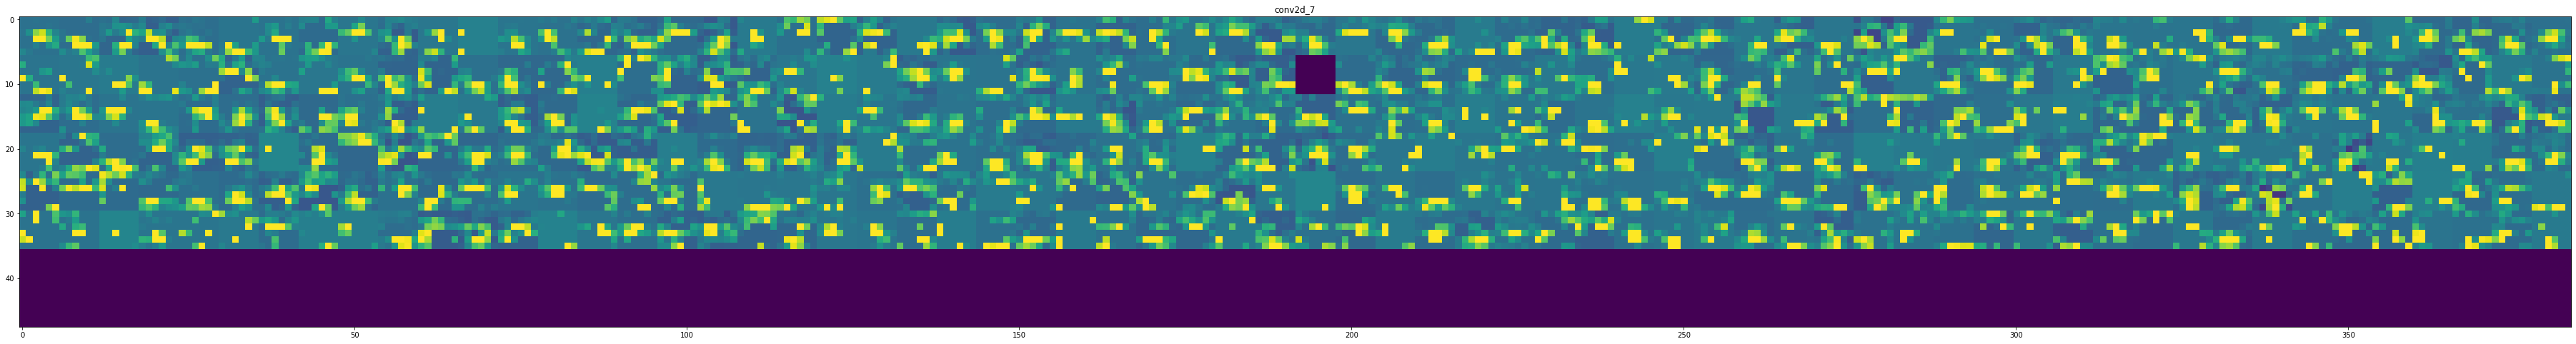

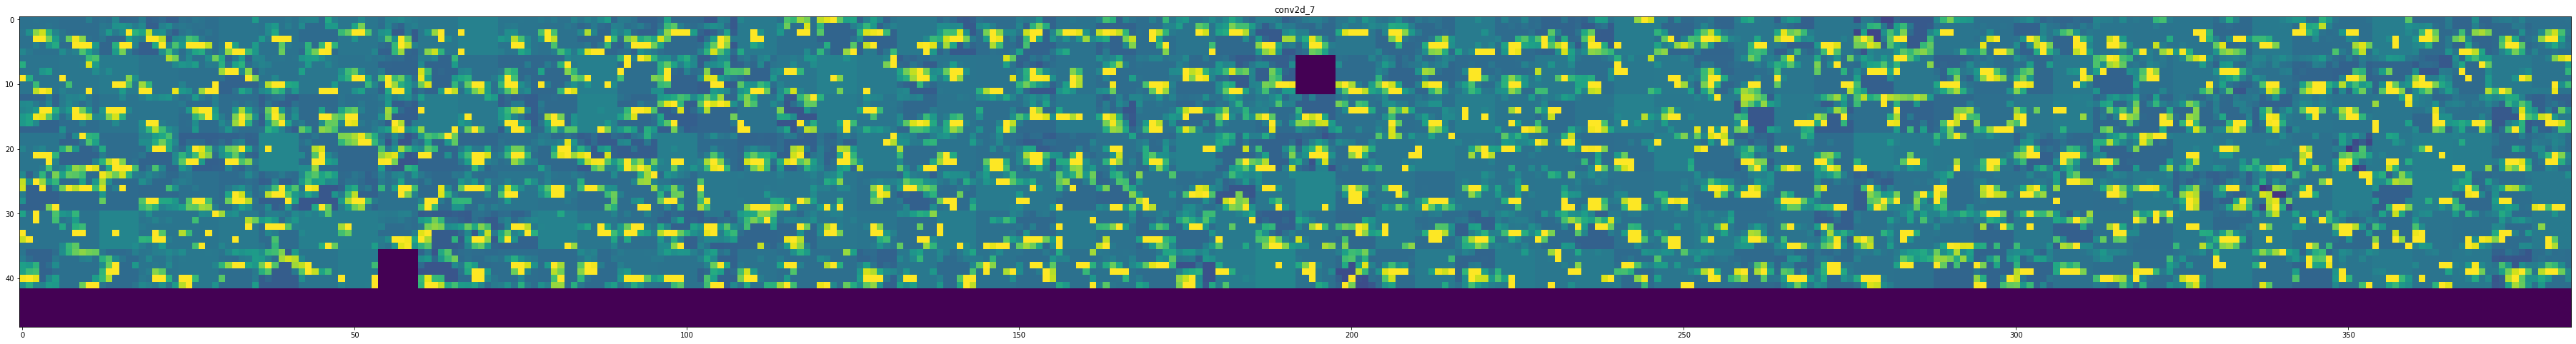

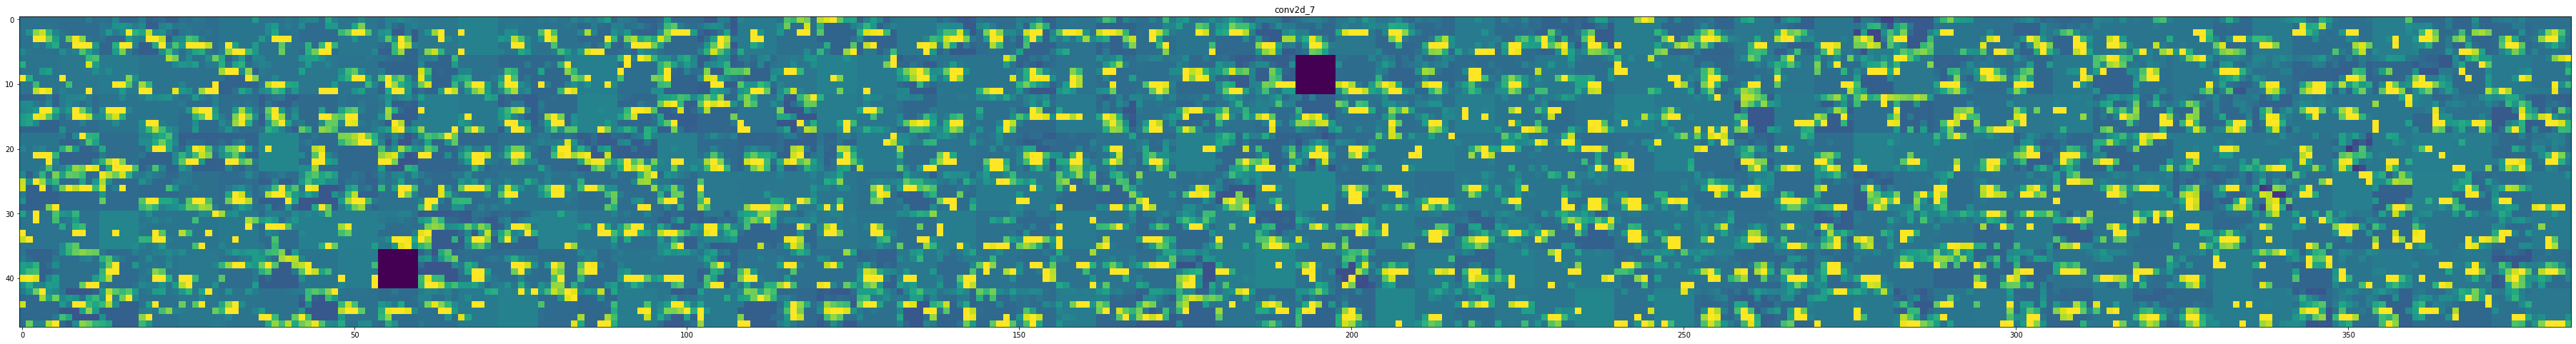

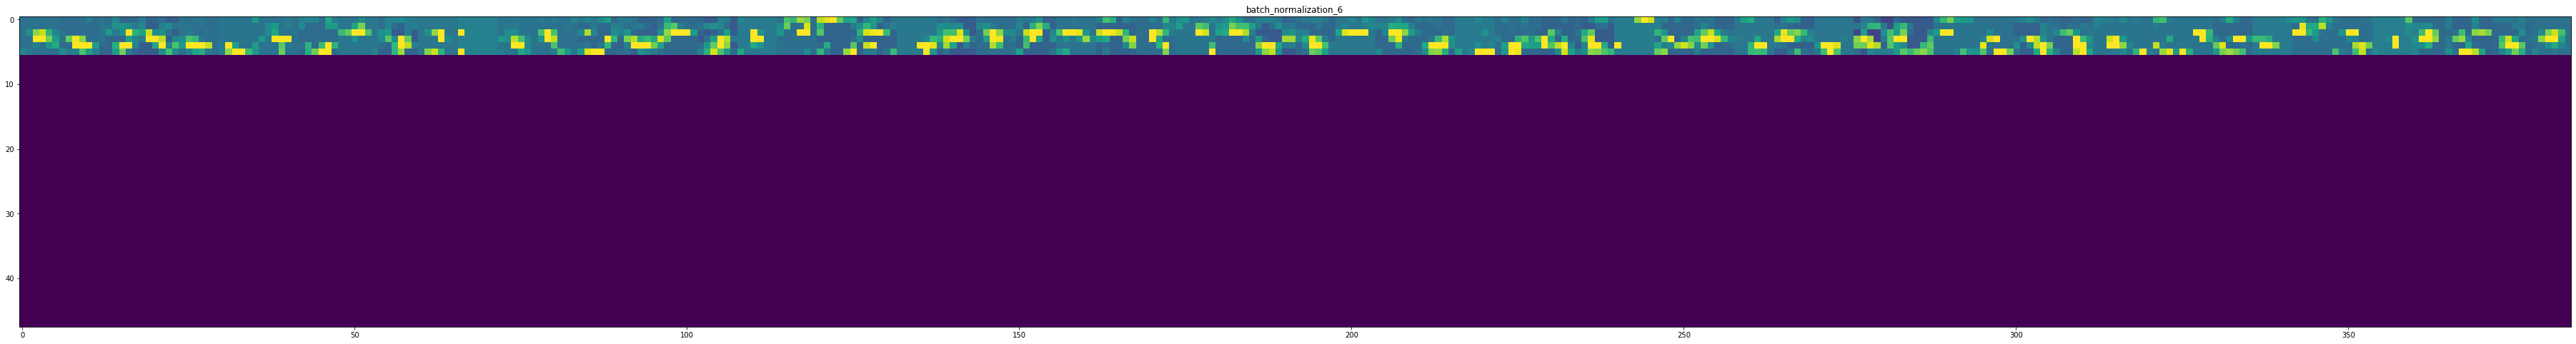

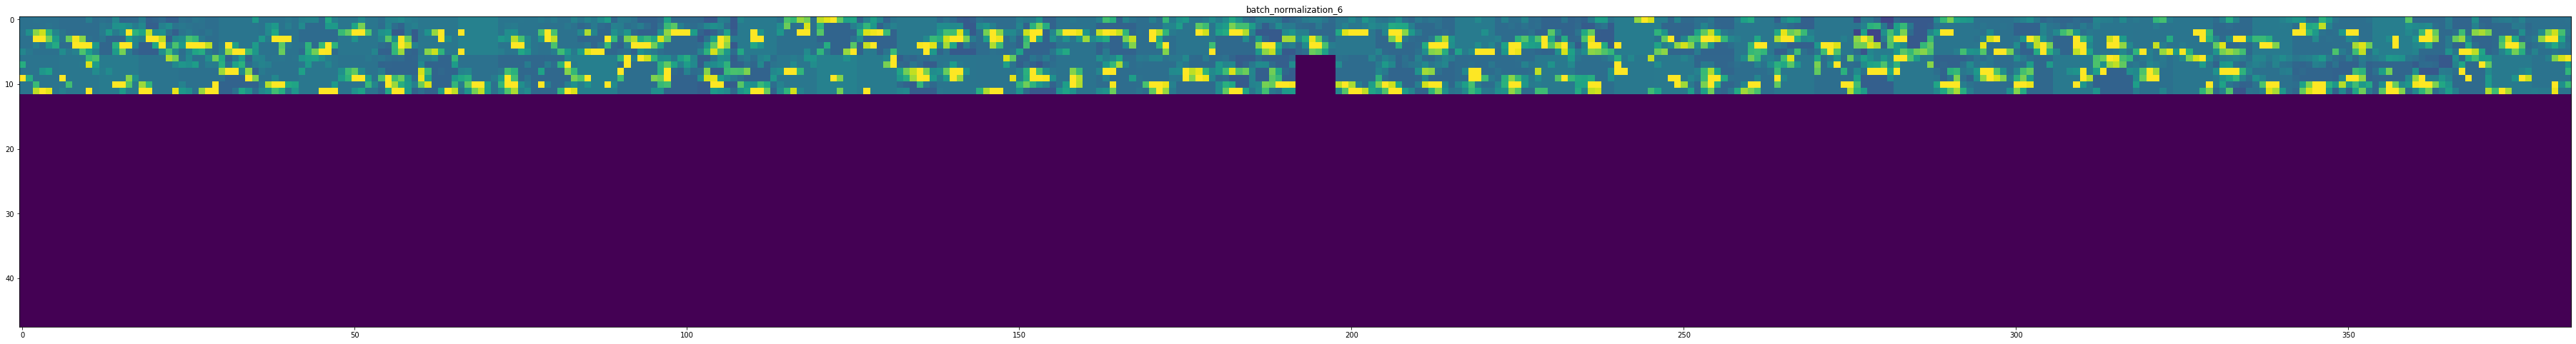

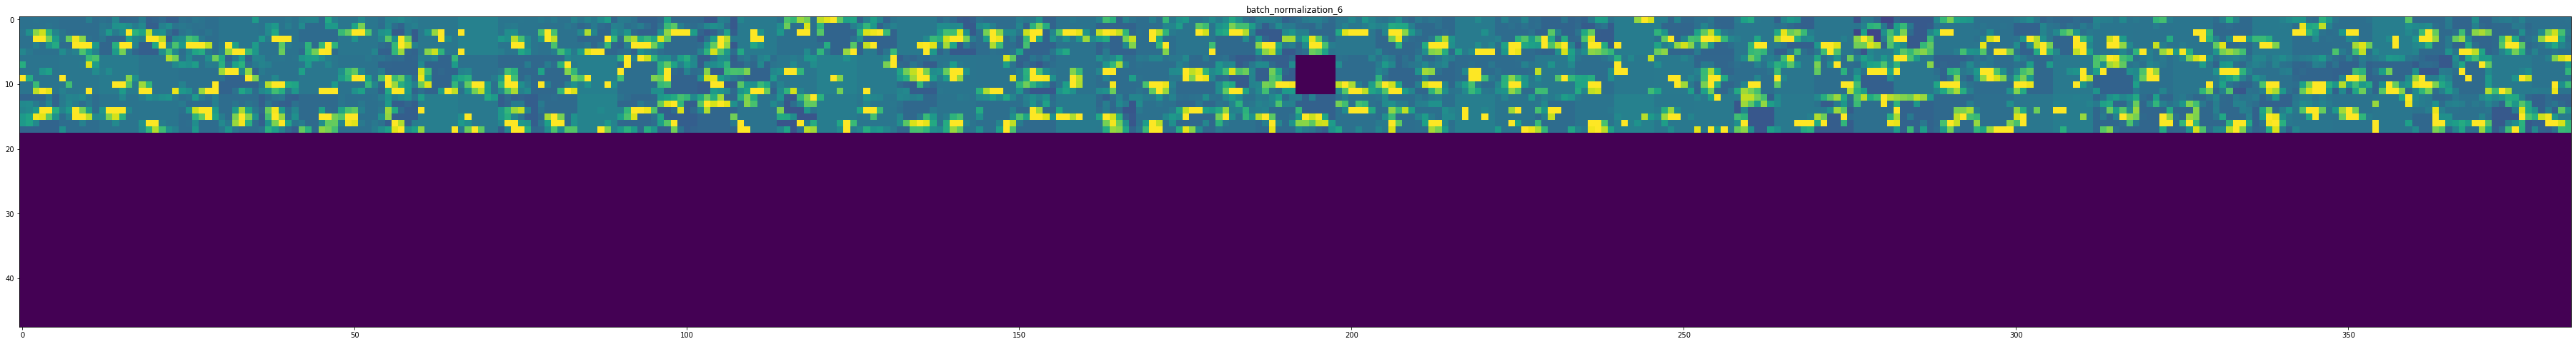

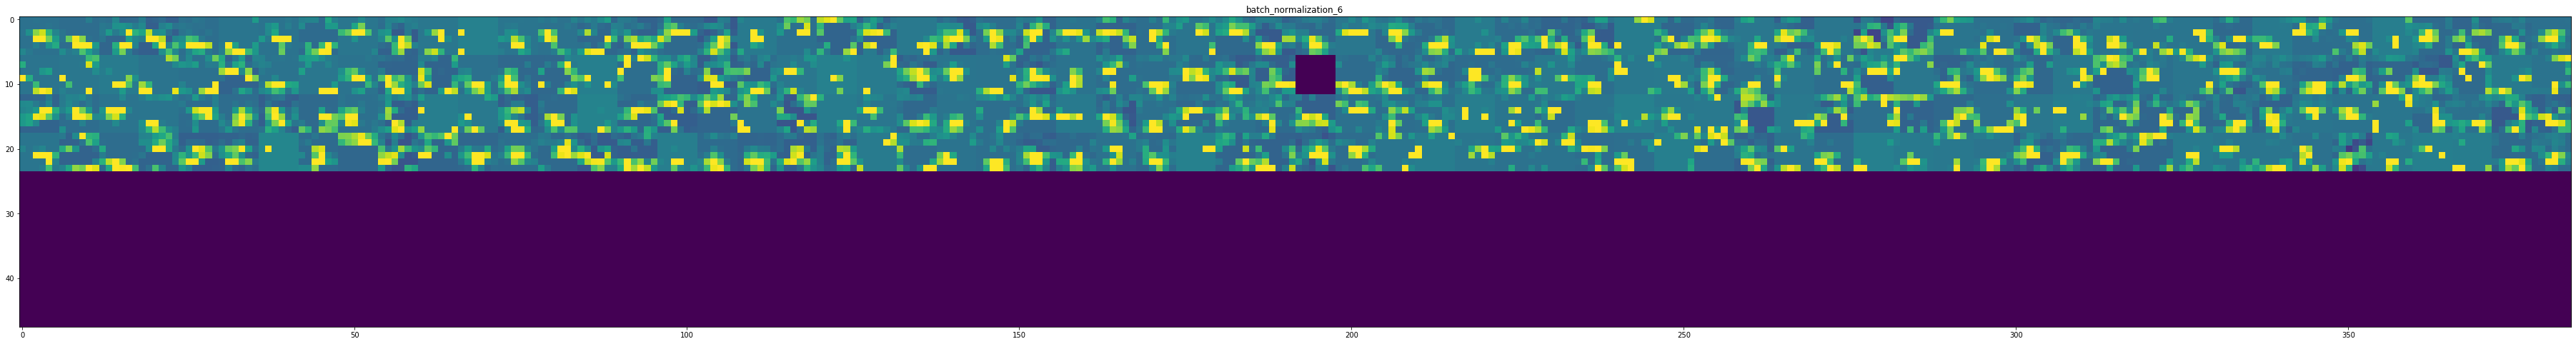

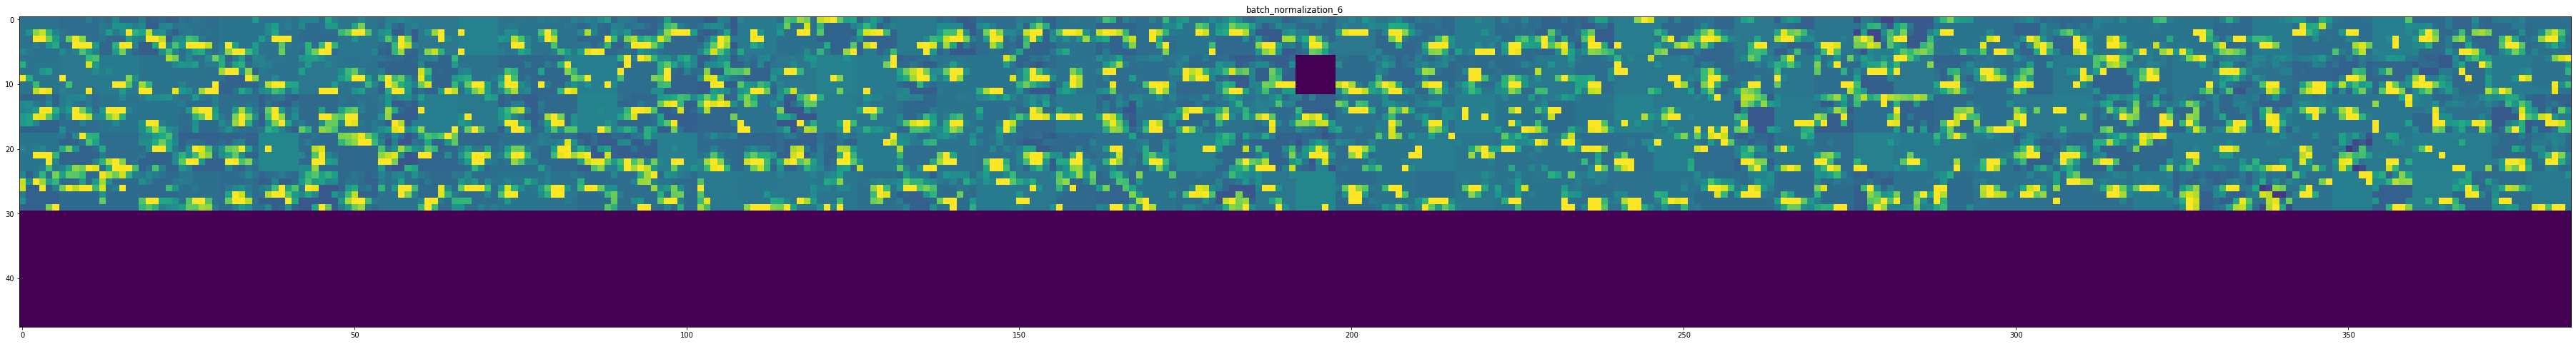

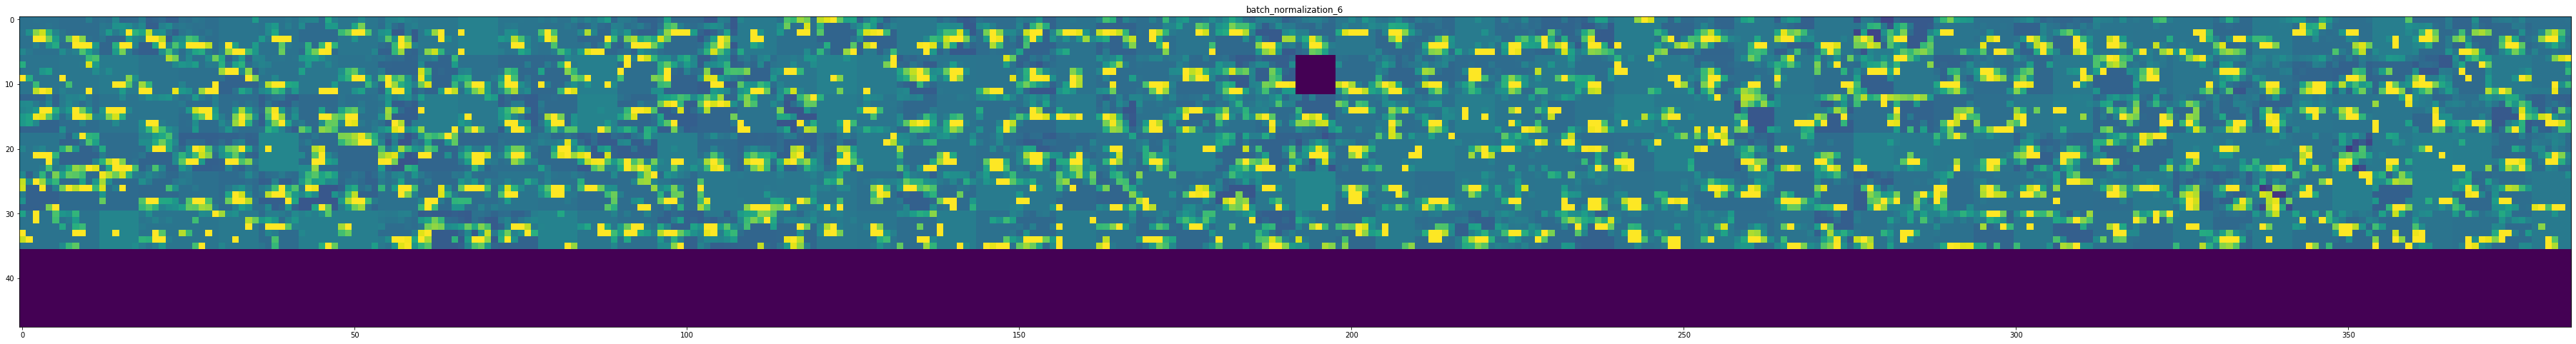

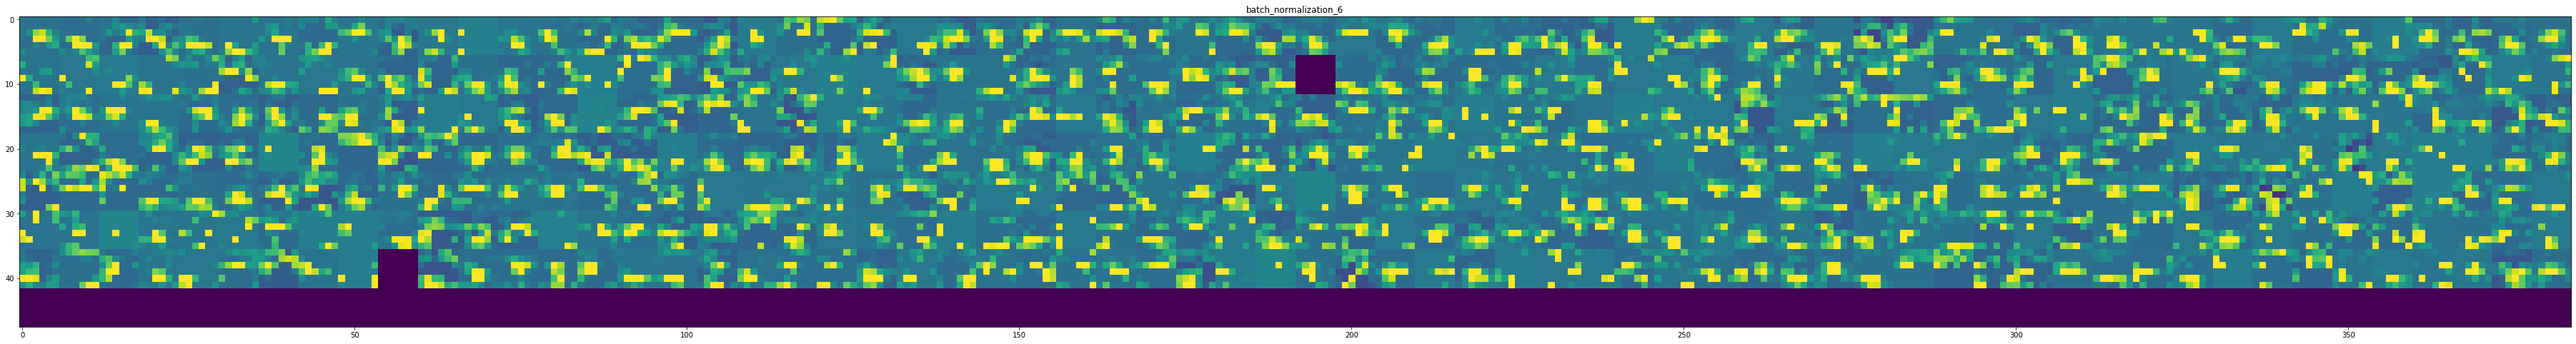

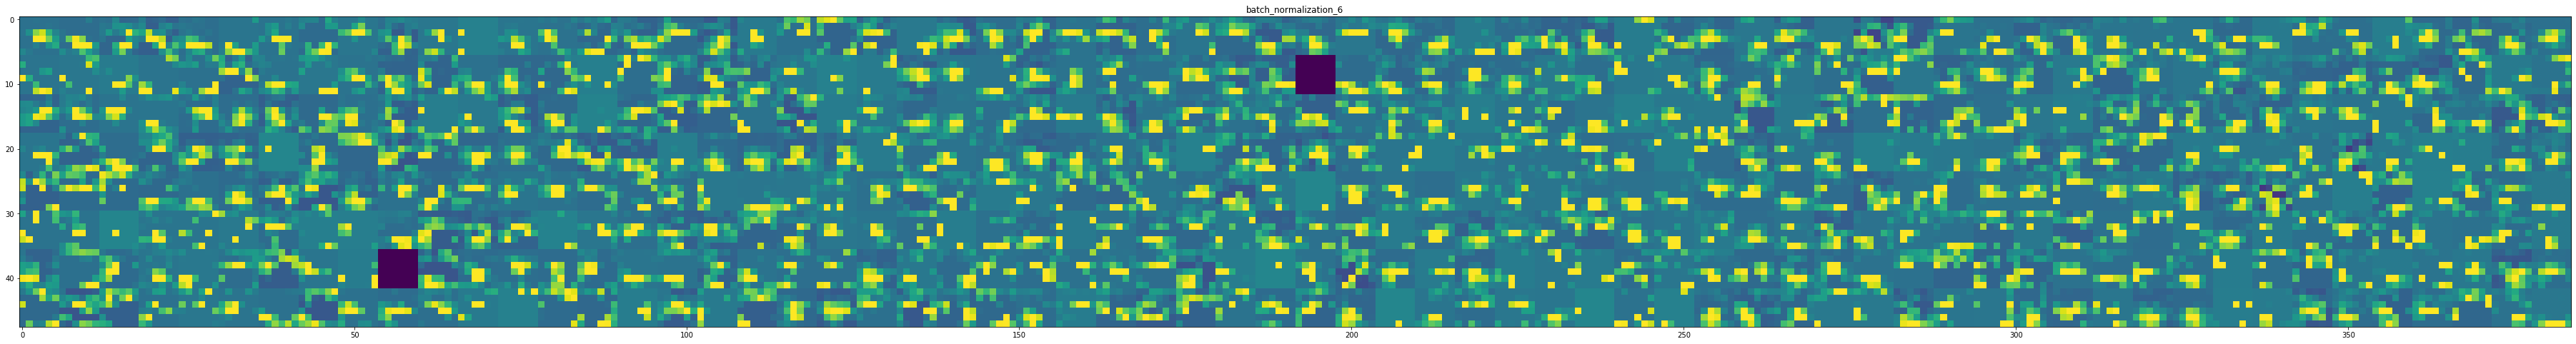

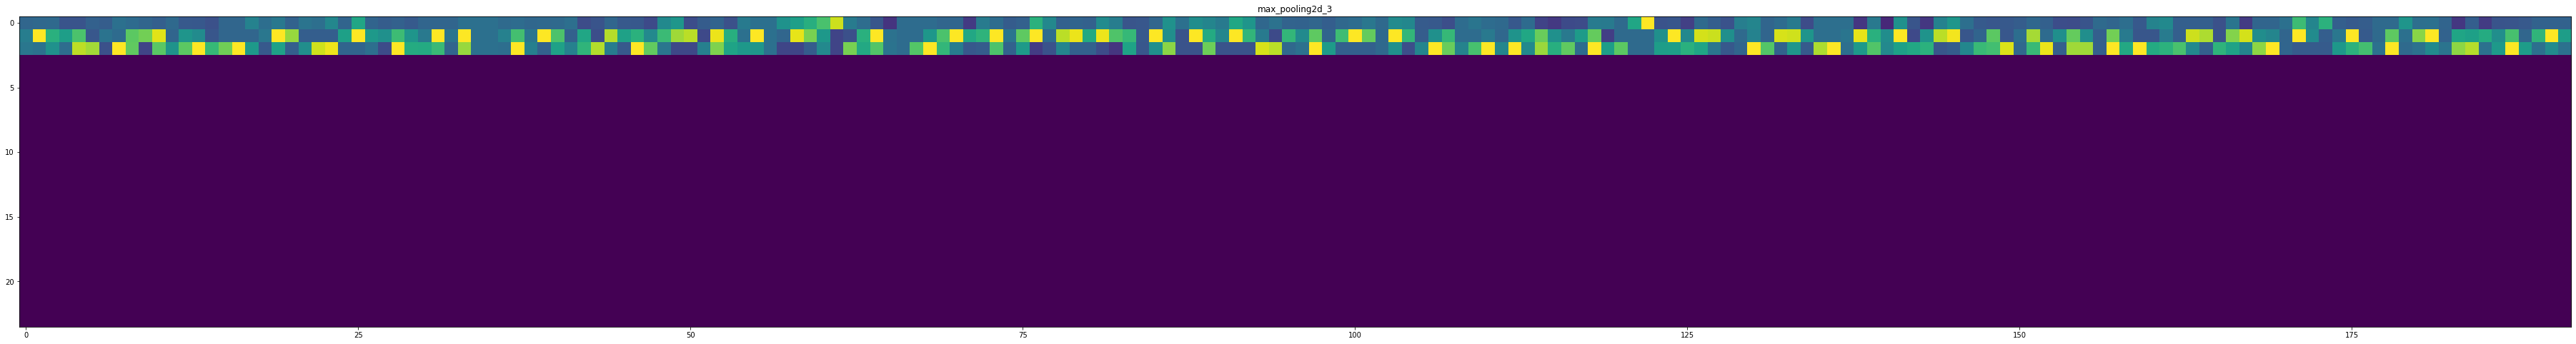

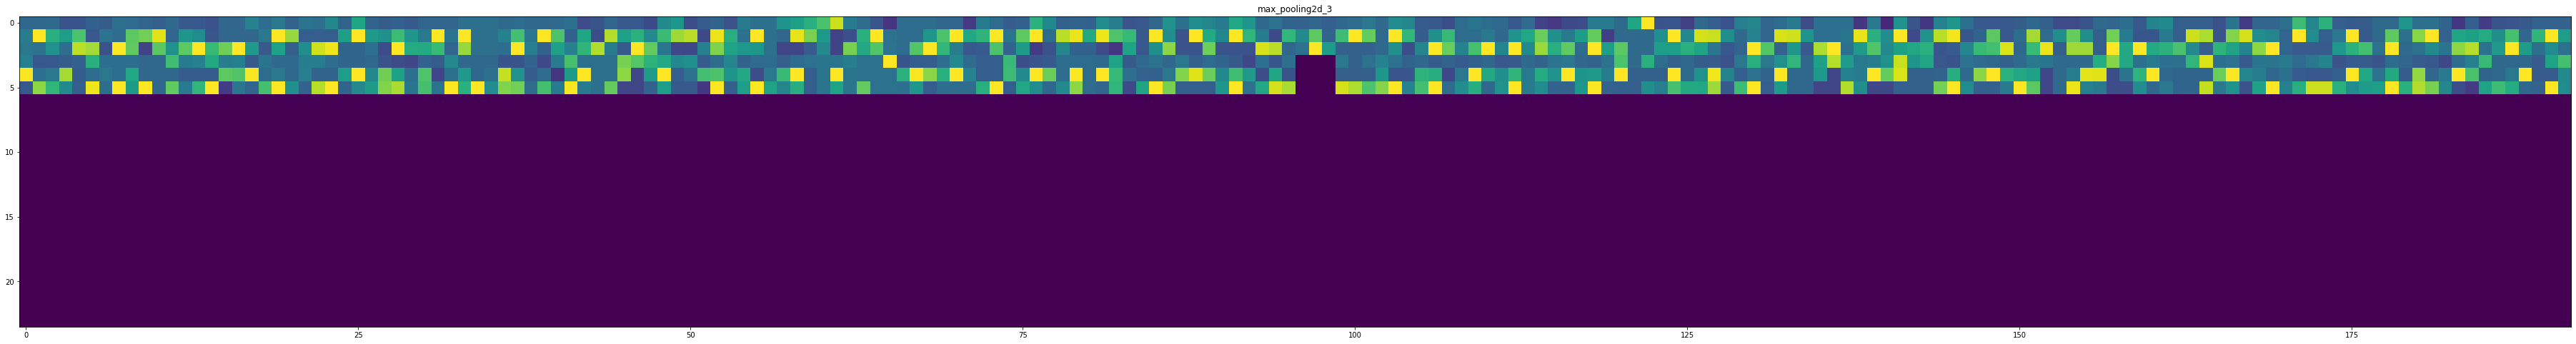

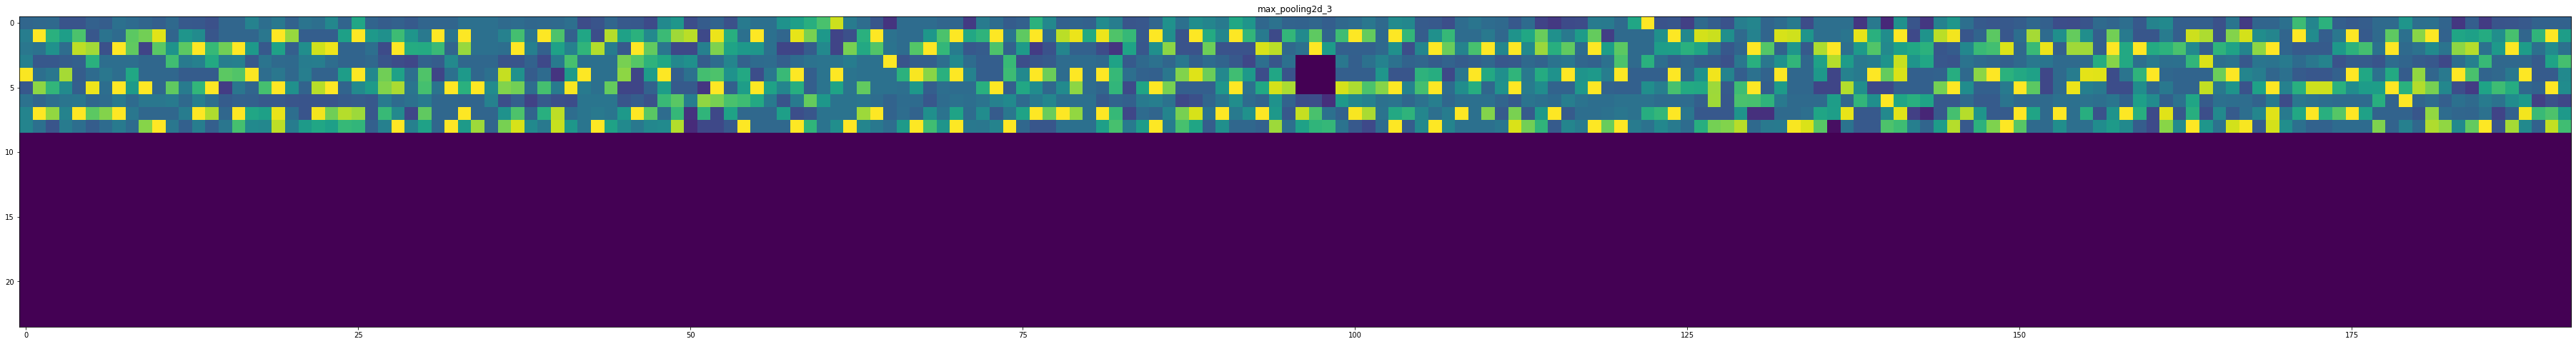

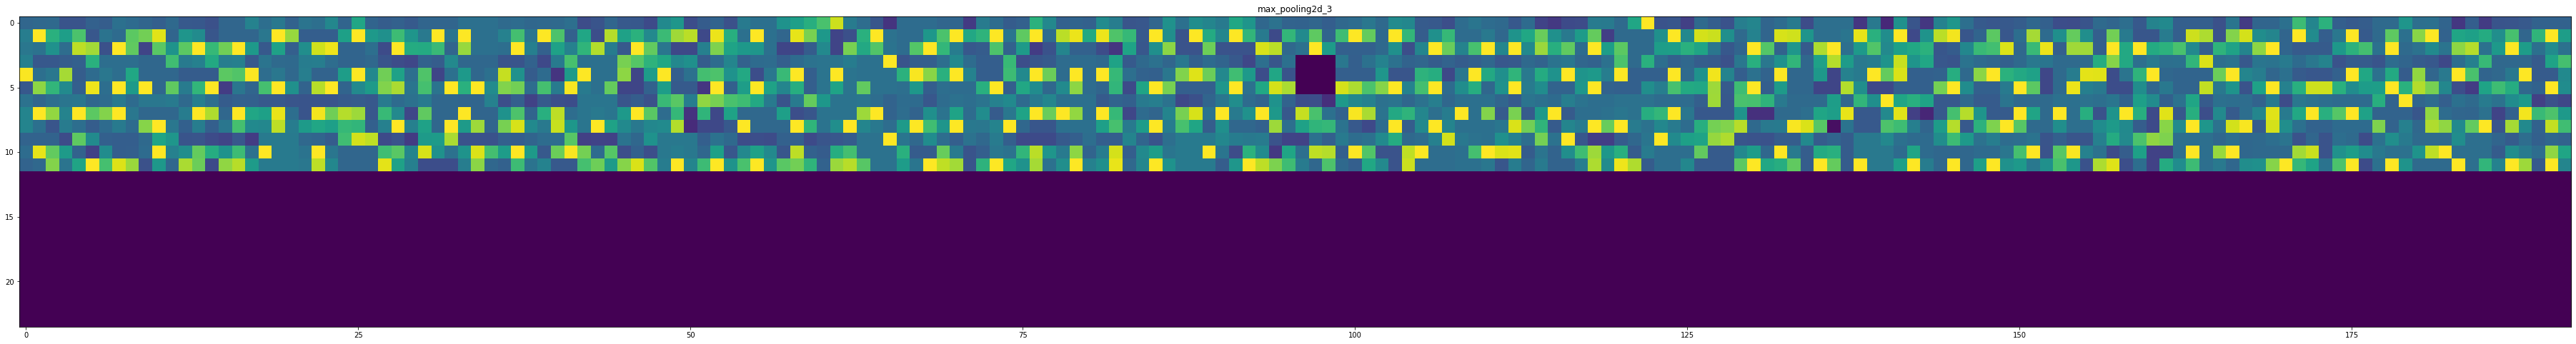

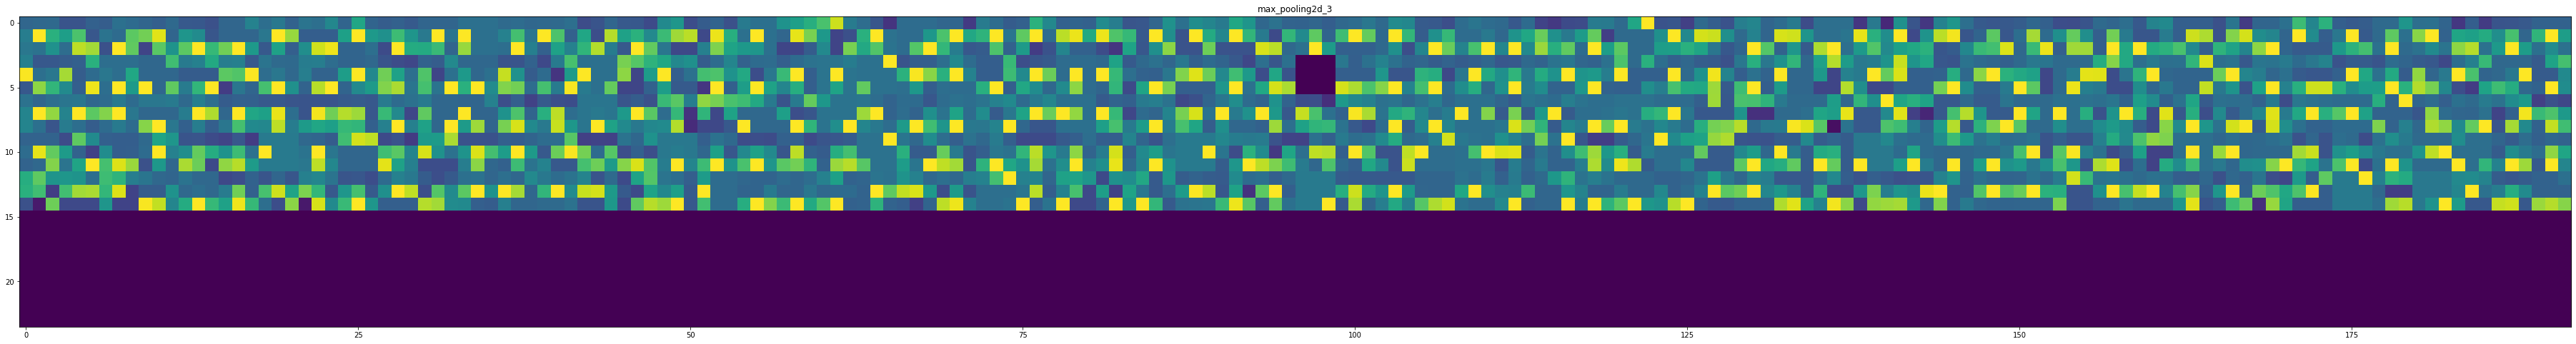

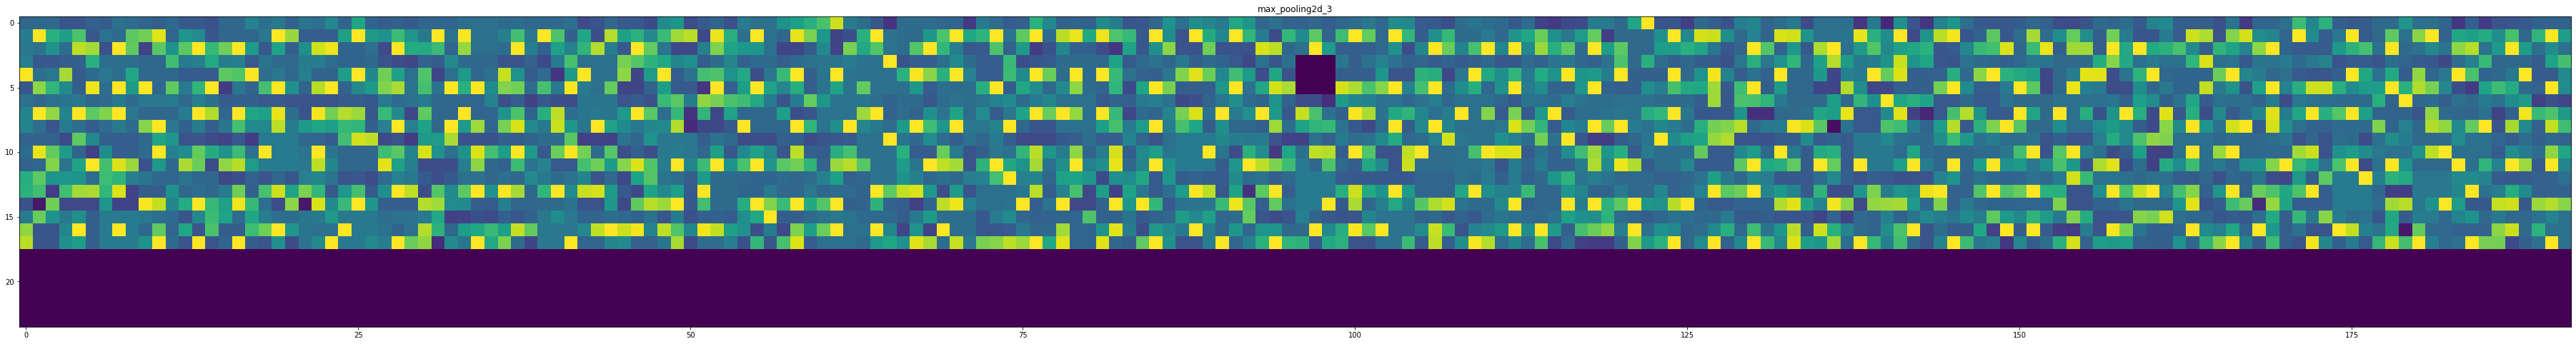

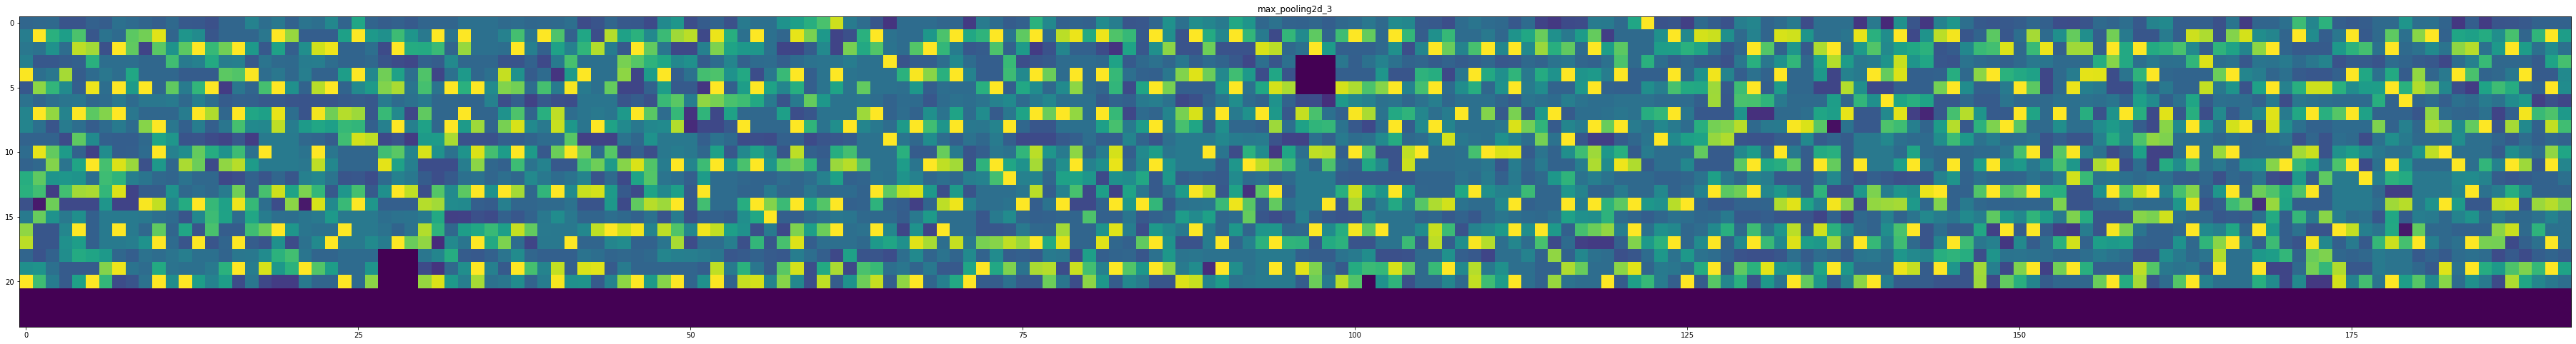

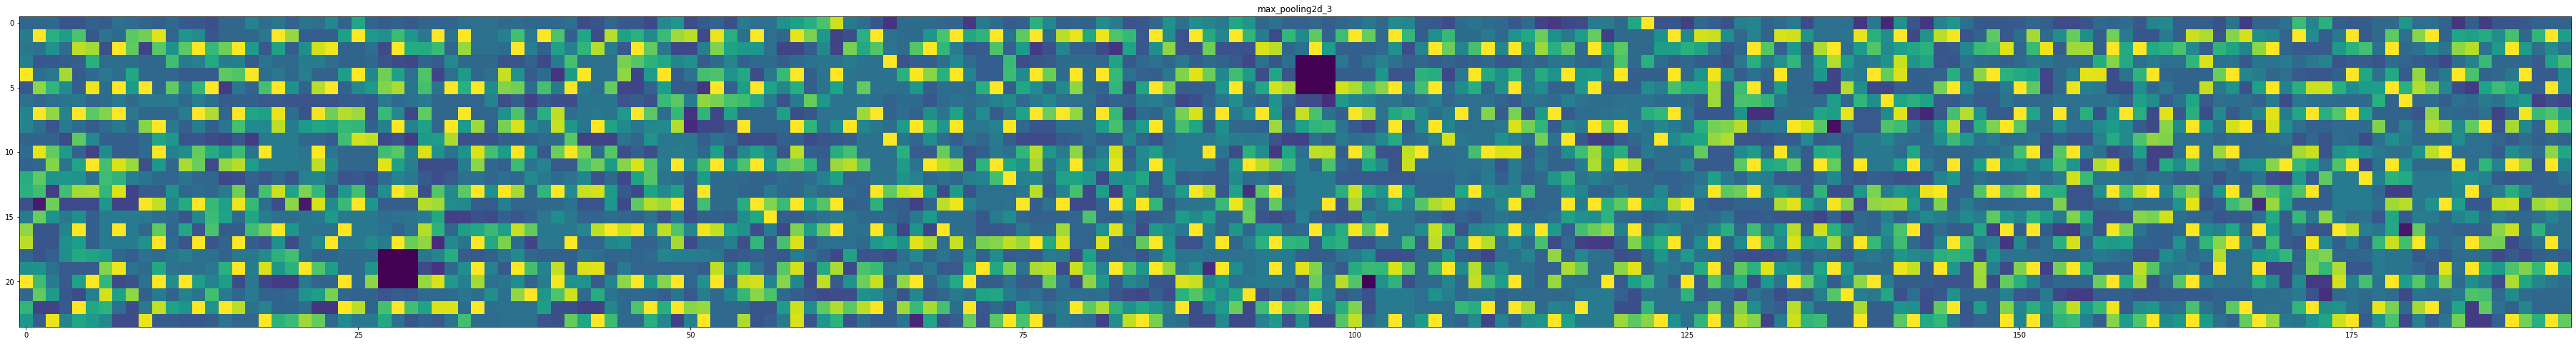

In [0]:
for layer_name,layer_activation in zip(layer_names, activations): # Displays the feature maps
  n_features = layer_activation.shape[-1] # Number of features in the feature map
  size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
  n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
  display_grid = np.zeros((size * n_cols, images_per_row * size))
  for col in range(n_cols): # Tiles each filter into a big horizontal grid
    for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [0]:
result_num = np.argmax(res)
print(result_num)

3


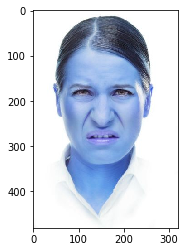

In [0]:
image = '/content/drive/My Drive/Datasets/test_images/person_d.jpg'
sample_face = cv2.imread(image, cv2.COLOR_BGR2RGB)
plt.imshow(sample_face)

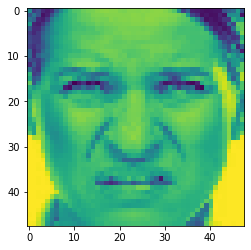

In [0]:
face1 = extract_face_features(detect_face(sample_face))[0]
plt.imshow(face1)

In [0]:
pred = np.reshape(face1.flatten(), (1,48,48,1))
res=model_fervideo_1.predict(pred)
result_num = np.argmax(res)
print(result_num)
print(get_label(result_num))

1
Disgust
